In [2]:
# -*- coding: utf-8 -*-
# Licensed under a 3-clause BSD style license - see LICENSE.rst
import logging
import os
import warnings
from collections import OrderedDict
from multiprocessing import Pool

import astropy
from astropy.table import Table, hstack
import astropy.units as u
from astropy.io import ascii
from astropy.constants import alpha, c, e, hbar, m_e, m_p, sigma_sb
from astropy.utils.data import get_pkg_data_filename
from astropy.cosmology import WMAP9 as cosmo

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter

from Validator import (
    validate_array,
    validate_physical_type,
    validate_scalar,
)
#from .model_utils import memoize
from Utils import trapz_loglog

import Models
import Radiative
import grbloader
from GRBmodel import GRBModel1
from Models import EblAbsorptionModel

from astropy.units import def_physical_type

try:
    #def_physical_type(u.Unit("1 / eV"), "differential energy")
    def_physical_type(u.erg / u.cm**2 / u.s, "flux")
    def_physical_type(u.Unit("1/(s cm2 erg)"), "differential flux")
    def_physical_type(u.Unit("1/(s erg)"), "differential power")
    def_physical_type(u.Unit("1/TeV"), "differential energy")
    def_physical_type(u.Unit("1/cm3"), "number density")
    def_physical_type(u.Unit("1/(eV cm3)"), "differential number density")

except ValueError:
    print("New quantities already defined")

New quantities already defined


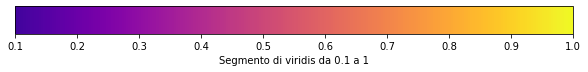

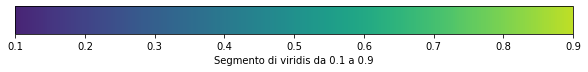

In [3]:
from matplotlib import cm
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

vmin = 0.1
vmax = 1
original_cmap = plt.cm.plasma

cmap1 = truncate_colormap(original_cmap, vmin, vmax)
fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)
norm = Normalize(vmin, vmax)  # da 0 a 1 perché stai solo mostrando il segmento
cb = ColorbarBase(ax,cmap=cmap1,norm=norm,orientation='horizontal')
cb.set_label(f'Segmento di viridis da {vmin} a {vmax}')
plt.show()

vmin = 0.1
vmax = 0.9
original_cmap2 = plt.cm.viridis

cmap2 = truncate_colormap(original_cmap2, vmin, vmax)
fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)
norm = Normalize(vmin, vmax)  # da 0 a 1 perché stai solo mostrando il segmento
cb = ColorbarBase(ax,cmap=cmap2,norm=norm,orientation='horizontal')
cb.set_label(f'Segmento di viridis da {vmin} a {vmax}')
plt.show()

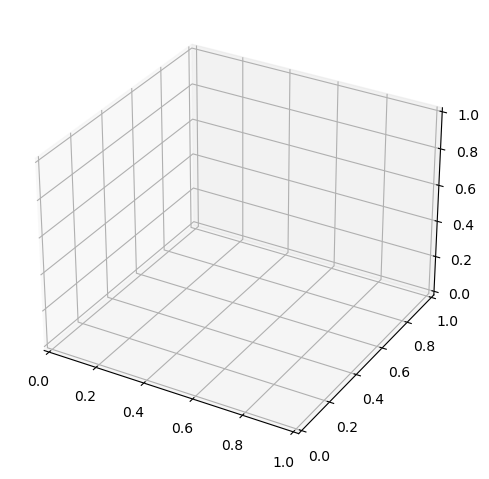

In [4]:
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import numpy as np

#Criando uma função periodica
def PS(x, y, t):
    return np.sin(y**2 + t) + np.cos(x**2 + t)

#Dados para aplicar na função 
x = np.linspace(-np.pi, np.pi, 101)
y = np.linspace(-np.pi, np.pi, 101)
t = np.linspace(0, 20, 101)

#Cria matrizes de coordenadas a partir das coords x e y
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize = (12, 6), dpi = 100)     
ax = fig.gca(projection = '3d')

#Esta função é chamada periodicamente a partir da FuncAnimation
def update(i):
    Z = PS(X, Y, t[i])
    ax.clear()
    ax.plot_surface(X, Y, Z, cmap = mpl.cm.viridis)
    plt.title(str(i))
    plt.xlabel('$X$', color = 'g')
    plt.ylabel('$Y$', color = 'g')

#Plotagem para chamar a função update() periodicamente
ani = animation.FuncAnimation(fig, update, np.arange(100), interval = 10, repeat = False)

plt.show()

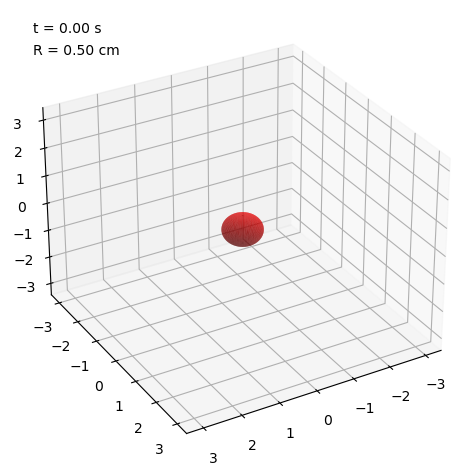

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D

# Parametri
t_start = 0
t_end = 5
frames = 50
times = np.linspace(t_start, t_end, frames)
radii = 0.5 + 0.5 * times  # esempio: r(t) = 0.5 + 0.5 * t

# Crea la figura e l'asse 3D
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('white')

# Limiti assi
limit = max(radii) * 1.1
ax.set_xlim([-limit, limit])
ax.set_ylim([-limit, limit])
ax.set_zlim([-limit, limit])

# Vista fissa
ax.view_init(elev=30, azim=60)

# Funzione di aggiornamento per l'animazione
def update(frame):
    ax.cla()  # Pulisce l'asse per il nuovo frame

    # Parametri per il frame corrente
    t = times[frame]
    raggio = radii[frame]

    # Griglia sferica
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = raggio * np.outer(np.cos(u), np.sin(v))
    y = raggio * np.outer(np.sin(u), np.sin(v))
    z = raggio * np.outer(np.ones(np.size(u)), np.cos(v))

    # Plot della sfera
    ax.plot_surface(x, y, z, color='red', alpha=0.6, edgecolor='none')

    # Etichette testo
    ax.text2D(0.05, 0.95, f"t = {t:.2f} s", transform=ax.transAxes)
    ax.text2D(0.05, 0.90, f"R = {raggio:.2f} cm", transform=ax.transAxes)

    # Limiti assi
    ax.set_xlim([-limit, limit])
    ax.set_ylim([-limit, limit])
    ax.set_zlim([-limit, limit])

    # Vista fissa
    ax.view_init(elev=30, azim=60)

# Crea l'animazione
ani = FuncAnimation(fig, update, frames=frames, repeat=False)

# Salva l'animazione come GIF
ani.save("sfera_espansione.gif", writer=PillowWriter(fps=10))


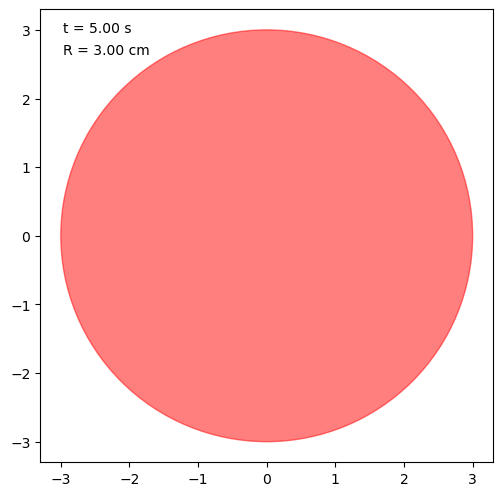

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Parametri temporali
t_start = 0
t_end = 5
frames = 50
times = np.linspace(t_start, t_end, frames)
radii = 0.5 + 0.5 * times  # r(t)

# Crea la figura 2D
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
ax.set_aspect('equal')
limit = max(radii) * 1.1
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)

# Oggetti grafici da aggiornare
circle = plt.Circle((0, 0), radii[0], color='red', alpha=0.5)
ax.add_patch(circle)
time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)
radius_text = ax.text(0.05, 0.90, '', transform=ax.transAxes)

# Funzione di aggiornamento
def update(frame):
    r = radii[frame]
    circle.set_radius(r)
    time_text.set_text(f't = {times[frame]:.2f} s')
    radius_text.set_text(f'R = {r:.2f} cm')
    return circle, time_text, radius_text

# Crea animazione
ani = FuncAnimation(fig, update, frames=frames, blit=True)
ani.save("sezione_equatoriale.gif", writer=PillowWriter(fps=10))


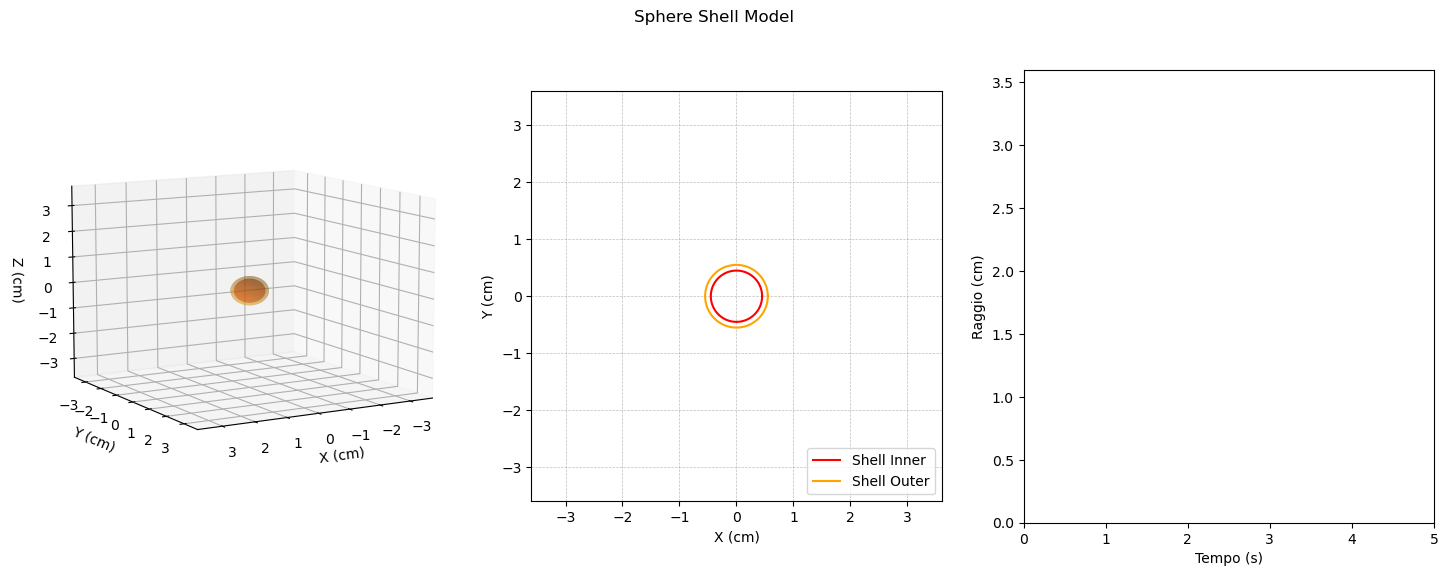

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter

#------------------- temporal contarints -------------------------
t_start = 0
t_end = 5
frames = 50
times = np.linspace(t_start, t_end, frames)
radii = 0.5 + 0.5 * times  # r(t)
#-------------------------------------------------------------------

fig = plt.figure(figsize=(18, 6), dpi=100)
fig.suptitle("Sphere Shell Model")

# 3D subplot
ax3d = fig.add_subplot(131, projection='3d')
ax3d.set_facecolor('white')
ax3d.view_init(elev=30, azim=60)

# 2D subplot per sezioni
ax2d = fig.add_subplot(132)
ax2d.set_aspect('equal')


# 2D subplot per grafico raggio vs tempo
ax1d = fig.add_subplot(133)
ax1d.set_xlim([t_start, t_end])
ax1d.set_ylim([0, max(radii)*1.2])
ax1d.set_xlabel("Tempo (s)")
ax1d.set_ylabel("Raggio (cm)")

# Limiti comuni per i grafici
limit = max(radii) * 1.2
for ax in [ax3d, ax2d]:
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
if hasattr(ax3d, "set_zlim"):  # just in case
    ax3d.set_zlim(-limit, limit)

# Precompute sfera
u = np.linspace(0, 2 * np.pi, 60)
v = np.linspace(0, np.pi, 30)
U, V = np.meshgrid(u, v)
X = np.cos(U) * np.sin(V)
Y = np.sin(U) * np.sin(V)
Z = np.cos(V)

# Griglie polar coordinate per sezioni
theta = np.linspace(0, 2 * np.pi, 100)
grid_r = np.linspace(0, 1.0, 5)

# Cerchi iniziali sezioni
circle_xy, = ax2d.plot([], [], 'r', lw=2, label='XY (Z=0)')
circle_xz, = ax2d.plot([], [], 'b--', lw=1, label='XZ (Y=0)')
circle_yz, = ax2d.plot([], [], 'g--', lw=1, label='YZ (X=0)')

# Testo per il tempo e il raggio
time_text = ax2d.text(0.05, 0.95, '', transform=ax2d.transAxes)
radius_text = ax2d.text(0.05, 0.90, '', transform=ax2d.transAxes)

# Linea per il grafico del raggio
line_raggio, = ax1d.plot([], [], color='blue', lw=2)

# Funzione di aggiornamento
def update(frame):
    r = radii[frame]
    delta_r = 0.2 * r  # ad esempio 20% dello spessore
    r_in = r - delta_r / 2
    r_out = r + delta_r / 2

    # === Shell 3D ===
    ax3d.cla()
    ax3d.set_xlim(-limit, limit)
    ax3d.set_ylim(-limit, limit)
    ax3d.set_zlim(-limit, limit)
    ax3d.view_init(elev=10, azim=60)
    ax3d.set_xlabel("X (cm)")
    ax3d.set_ylabel("Y (cm)")
    ax3d.set_zlabel("Z (cm)")

    # Superfici interna ed esterna della shell
    ax3d.plot_surface(r_in * X, r_in * Y, r_in * Z, color='red', alpha=0.3, edgecolor='none')
    ax3d.plot_surface(r_out * X, r_out * Y, r_out * Z, color='orange', alpha=0.3, edgecolor='none')

    # === Sezione 2D ===
    ax2d.cla()
    ax2d.set_xlim(-limit, limit)
    ax2d.set_ylim(-limit, limit)
    ax2d.set_aspect('equal')
    ax2d.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax2d.set_xlabel("X (cm)")
    ax2d.set_ylabel("Y (cm)")

    # Due cerchi concentrici per la shell
    ax2d.plot(r_in * np.cos(theta), r_in * np.sin(theta), 'r', lw=1.5, label='Shell Inner')
    ax2d.plot(r_out * np.cos(theta), r_out * np.sin(theta), 'orange', lw=1.5, label='Shell Outer')

    # === Grafico raggio vs tempo ===
    line_raggio.set_data(times[:frame+1], radii[:frame+1])

    # Aggiorna il testo per il tempo e il raggio
    time_text.set_text(f't = {times[frame]:.2f} s')
    radius_text.set_text(f'R = {r:.2f} cm')
    ax2d.legend(loc='lower right')

    return [circle_xy, line_raggio]

# Crea animazione
ani = FuncAnimation(fig, update, frames=frames, blit=False)
ani.save("espansione_sfera_con_sezioni_e_raggio.gif", writer=PillowWriter(fps=10))


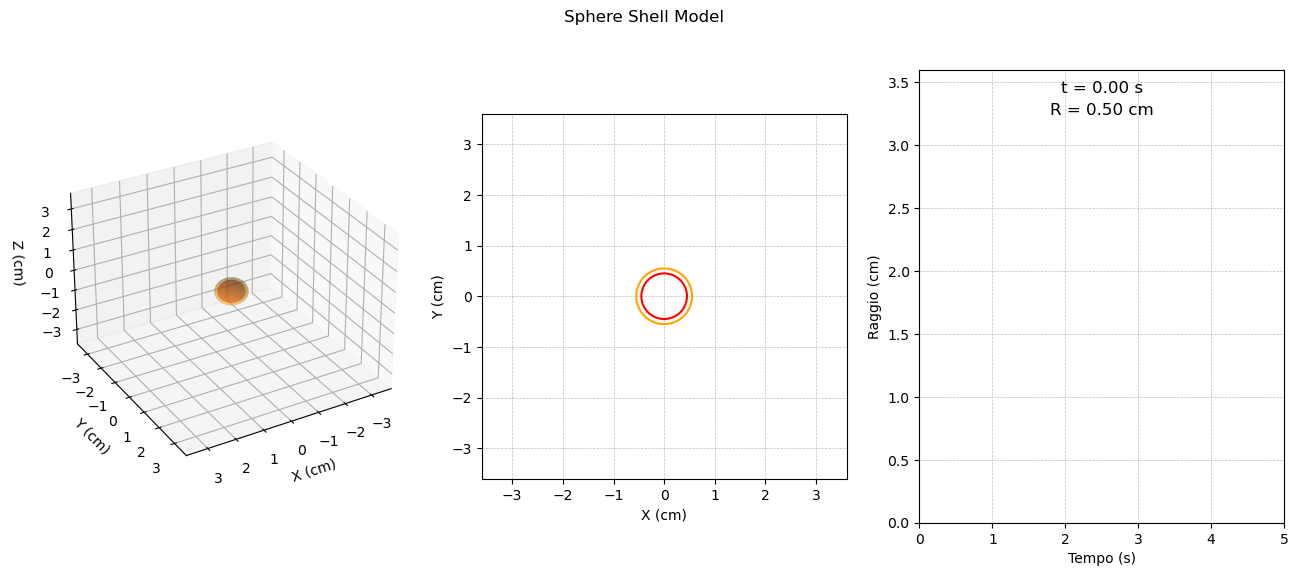

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter

#------------------- temporal constraints -------------------------
t_start = 0
t_end = 5
frames = 50
times = np.linspace(t_start, t_end, frames)
radii = 0.5 + 0.5 * times  # r(t)
#-------------------------------------------------------------------

fig = plt.figure(figsize=(16, 6), dpi=100)
fig.suptitle("Sphere Shell Model")

# 3D subplot
ax3d = fig.add_subplot(131, projection='3d')
ax3d.set_facecolor('white')
ax3d.view_init(elev=20, azim=60)

# 2D subplot per sezioni
ax2d = fig.add_subplot(132)
ax2d.set_aspect('equal')

# 2D subplot per grafico raggio vs tempo
ax1d = fig.add_subplot(133)
ax1d.set_xlim([t_start, t_end])
ax1d.set_ylim([0, max(radii)*1.2])
ax1d.set_xlabel("Tempo (s)")
ax1d.set_ylabel("Raggio (cm)")

# Limiti comuni per i grafici
limit = max(radii) * 1.2
for ax in [ax3d, ax2d]:
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
if hasattr(ax3d, "set_zlim"):  # just in case
    ax3d.set_zlim(-limit, limit)

# Precompute sfera
u = np.linspace(0, 2 * np.pi, 60)
v = np.linspace(0, np.pi, 30)
U, V = np.meshgrid(u, v)
X = np.cos(U) * np.sin(V)
Y = np.sin(U) * np.sin(V)
Z = np.cos(V)

# Griglie polar coordinate per sezioni
theta = np.linspace(0, 2 * np.pi, 100)
grid_r = np.linspace(0, 1.0, 5)

# Cerchi iniziali sezioni
circle_xy, = ax2d.plot([], [], 'r', lw=2, label='XY (Z=0)')
circle_xz, = ax2d.plot([], [], 'b--', lw=1, label='XZ (Y=0)')
circle_yz, = ax2d.plot([], [], 'g--', lw=1, label='YZ (X=0)')

# Linea per il grafico del raggio
line_raggio, = ax1d.plot([], [], color='blue', lw=2)

# Variabili globali per il testo
time_text = None
radius_text = None

# Funzione di aggiornamento
def update(frame):
    global time_text, radius_text
    
    r = radii[frame]
    delta_r = 0.2 * r  # ad esempio 20% dello spessore
    r_in = r - delta_r / 2
    r_out = r + delta_r / 2

    # === Shell 3D ===
    ax3d.cla()
    ax3d.set_xlim(-limit, limit)
    ax3d.set_ylim(-limit, limit)
    ax3d.set_zlim(-limit, limit)
    ax3d.view_init(elev=30, azim=60)
    #ax3d.text2D(0.05, 0.95, f"t = {times[frame]:.2f} s", transform=ax3d.transAxes)
    #ax3d.text2D(0.05, 0.90, f"R = {r:.2f} cm", transform=ax3d.transAxes)
    ax3d.set_xlabel("X (cm)")
    ax3d.set_ylabel("Y (cm)")
    ax3d.set_zlabel("Z (cm)")

    # Superfici interna ed esterna della shell
    ax3d.plot_surface(r_in * X, r_in * Y, r_in * Z, color='red', alpha=0.3, edgecolor='none')
    ax3d.plot_surface(r_out * X, r_out * Y, r_out * Z, color='orange', alpha=0.3, edgecolor='none')

    # === Sezione 2D ===
    ax2d.cla()
    ax2d.set_xlim(-limit, limit)
    ax2d.set_ylim(-limit, limit)
    ax2d.set_aspect('equal')
    ax2d.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax2d.set_xlabel("X (cm)")
    ax2d.set_ylabel("Y (cm)")

    # Due cerchi concentrici per la shell
    ax2d.plot(r_in * np.cos(theta), r_in * np.sin(theta), 'r', lw=1.5, label='Shell Inner')
    ax2d.plot(r_out * np.cos(theta), r_out * np.sin(theta), 'orange', lw=1.5, label='Shell Outer')

    # === Grafico raggio vs tempo ===
    line_raggio.set_data(times[:frame+1], radii[:frame+1])

    # Rimuovere il testo precedente, se esiste
    if time_text is not None:
        time_text.remove()
    if radius_text is not None:
        radius_text.remove()

    # Aggiungere il nuovo testo nel grafico raggio vs tempo
    time_text = ax1d.text(0.5, 0.95, f't = {times[frame]:.2f} s', transform=ax1d.transAxes, ha='center', fontsize=12, color='black')
    radius_text = ax1d.text(0.5, 0.90, f'R = {r:.2f} cm', transform=ax1d.transAxes, ha='center', fontsize=12, color='black')
    ax1d.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    
    return [line_raggio]

# Crea animazione
ani = FuncAnimation(fig, update, frames=frames, blit=False)
ani.save("espansione_sfera_con_sezioni_e_raggio.gif", writer=PillowWriter(fps=10))


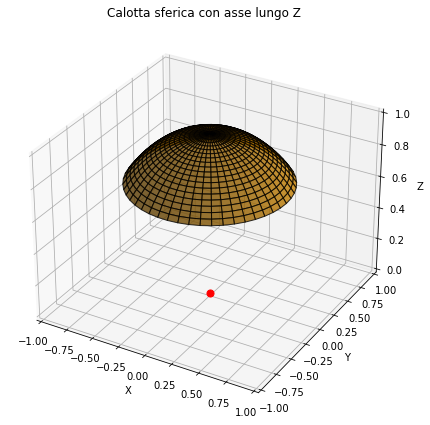

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parametri della calotta
R = 1.0                # Raggio della sfera
alpha = np.pi / 4      # Angolo di apertura della calotta (in radianti)

# Coordinate sferiche limitate all'intervallo [0, alpha] per theta (zenitale)
phi = np.linspace(0, 2 * np.pi, 50)              # angolo azimutale
theta = np.linspace(0, alpha, 20)                 # angolo zenitale

phi, theta = np.meshgrid(phi, theta)

# Conversione in coordinate cartesiane
X = R * np.sin(theta) * np.cos(phi)
Y = R * np.sin(theta) * np.sin(phi)
Z = R * np.cos(theta)

# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, color='orange', alpha=0.8, edgecolor='k')

# Aggiungi un punto rosso all'origine
ax.scatter(0, 0, 0, color='red', s=50)

# Imposta limiti e aspetto
ax.set_xlim([-R, R])
ax.set_ylim([-R, R])
ax.set_zlim([0, R])


ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("Calotta sferica con asse lungo Z")
plt.tight_layout()
plt.show()



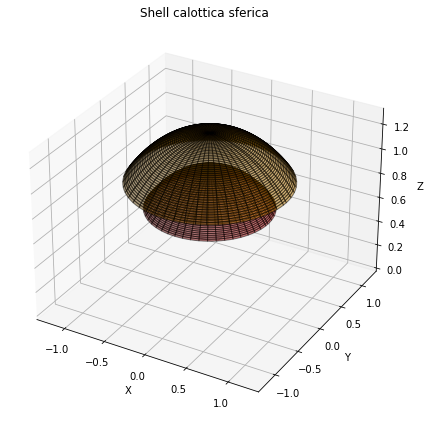

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parametri
R_inner = 1.0           # Raggio interno
R_outer = 1.3           # Raggio esterno
alpha = np.pi / 4       # Angolo di apertura della calotta (in radianti)

# Angoli sferici
phi = np.linspace(0, 2 * np.pi, 100)        # Azimutale
theta = np.linspace(0, alpha, 50)           # Zenitale
phi, theta = np.meshgrid(phi, theta)

# Calotta interna
X1 = R_inner * np.sin(theta) * np.cos(phi)
Y1 = R_inner * np.sin(theta) * np.sin(phi)
Z1 = R_inner * np.cos(theta)

# Calotta esterna
X2 = R_outer * np.sin(theta) * np.cos(phi)
Y2 = R_outer * np.sin(theta) * np.sin(phi)
Z2 = R_outer * np.cos(theta)

# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Superfici
ax.plot_surface(X1, Y1, Z1, color='red', alpha=0.5, edgecolor='k', label="Calotta interna")
ax.plot_surface(X2, Y2, Z2, color='orange', alpha=0.5, edgecolor='k', label="Calotta esterna")

# Punto origfrom mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
# Aspetto
ax.set_xlim([-R_outer, R_outer])
ax.set_ylim([-R_outer, R_outer])
ax.set_zlim([0, R_outer])


ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("Shell calottica sferica")
plt.tight_layout()
plt.show()


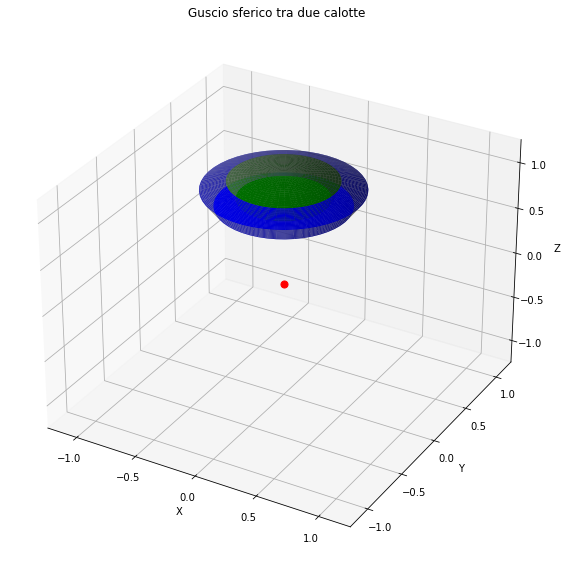

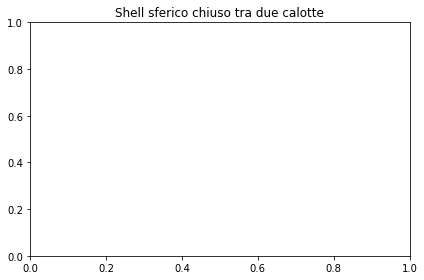

In [243]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter


# Parametri
R1 = 1.0
R2 = 1.2
alpha_in = np.deg2rad(20)
alpha_out = np.deg2rad(30)

# Risoluzione angolare
n_theta = 20
n_phi = 50

# Griglia per calotta interna
theta_in = np.linspace(alpha_in, alpha_out, n_theta)
phi = np.linspace(0, 2 * np.pi, n_phi)
theta_in, phi = np.meshgrid(theta_in, phi)

theta_in2 = np.linspace(np.deg2rad(0), np.deg2rad(20), n_theta)
phi2 = np.linspace(0, 2 * np.pi, n_phi)
theta_in2, phi2 = np.meshgrid(theta_in2, phi2)

# Coordinate calotta interna
X_in = np.sin(theta_in) * np.cos(phi)
Y_in = np.sin(theta_in) * np.sin(phi)
Z_in = np.cos(theta_in)

# Coordinate calotta esterna (stessa theta, solo scala diversa)
X_out = X_in.copy()
Y_out = Y_in.copy()
Z_out = Z_in.copy()


# Coordinate calotta interna
X_in2 = np.sin(theta_in2) * np.cos(phi2)
Y_in2 = np.sin(theta_in2) * np.sin(phi2)
Z_in2 = np.cos(theta_in2)

# Coordinate calotta esterna (stessa theta, solo scala diversa)
X_out2 = X_in2.copy()
Y_out2 = Y_in2.copy()
Z_out2 = Z_in2.copy()

# Superficie laterale tra R1 e R2 a theta = alpha_in
phi_wall = np.linspace(0, 2*np.pi, n_phi)
r_wall = np.linspace(R1, R2, n_theta)
phi_wall, r_wall = np.meshgrid(phi_wall, r_wall)
Xw1 = r_wall * np.sin(alpha_in) * np.cos(phi_wall)
Yw1 = r_wall * np.sin(alpha_in) * np.sin(phi_wall)
Zw1 = r_wall * np.cos(alpha_in) * np.ones_like(phi_wall)

# Superficie laterale a theta = alpha_out
Xw2 = r_wall * np.sin(alpha_out) * np.cos(phi_wall)
Yw2 = r_wall * np.sin(alpha_out) * np.sin(phi_wall)
Zw2 = r_wall * np.cos(alpha_out) * np.ones_like(phi_wall)

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Calotte
ax.plot_surface(R1*X_in, R1*Y_in, R1*Z_in, color='blue', alpha=1)
ax.plot_surface(R2*X_out, R2*Y_out, R2*Z_out, color='blue', alpha=1)

ax.plot_surface(R1*X_in2, R1*Y_in2, R1*Z_in2, color='green', alpha=1)
ax.plot_surface(R2*X_out2, R2*Y_out2, R2*Z_out2, color='green', alpha=1)

# Pareti laterali
ax.plot_surface(Xw1, Yw1, Zw1, color='gray', alpha=0.5)
ax.plot_surface(Xw2, Yw2, Zw2, color='gray', alpha=0.5)

# Origine
ax.scatter(0, 0, 0, color='red', s=50)

# Aspetto
ax.set_xlim([-R2, R2])
ax.set_ylim([-R2, R2])
ax.set_zlim([-R2, R2])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("Guscio sferico tra due calotte")
plt.tight_layout()
plt.show()
plt.title("Shell sferico chiuso tra due calotte")
plt.tight_layout()
plt.show()


[0.61086524 0.50905437 0.40724349 0.30543262 0.20362175 0.10181087
 0.        ]


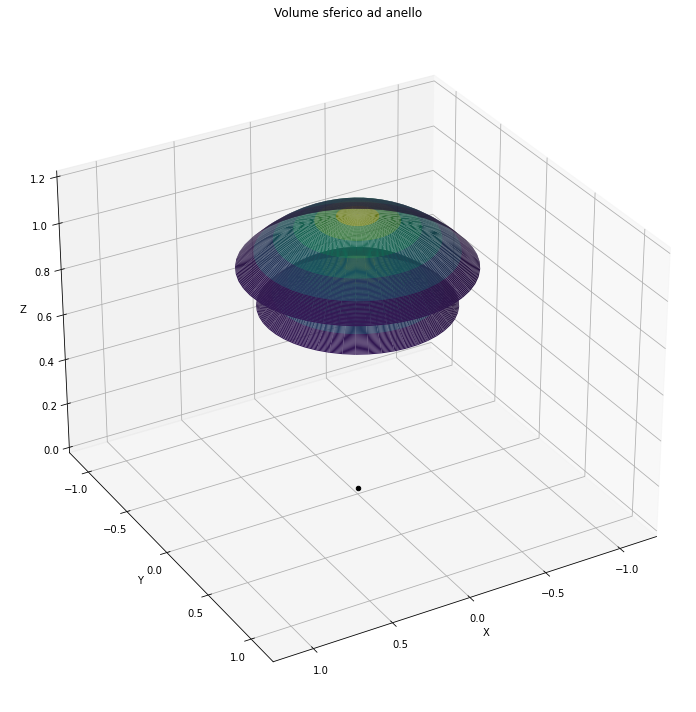

In [244]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

R1 = 1.0              # Raggio calotta interna
R2 = 1.2              # Raggio calotta esterna
rad_min= 0
rad_max = 35
alpha_min = np.deg2rad(rad_min)
alpha_max = np.deg2rad(rad_max)

n_theta = 20
n_phi = 50

n_shells = 6
alpha_rad_vals = np.linspace(alpha_max , alpha_min , n_shells + 1)
print(alpha_rad_vals)

# Plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

color=0

for i in range(n_shells):
    alpha_in=alpha_rad_vals[i]
    alpha_out=alpha_rad_vals[i+1]
    
    # Griglia angolare per calotte
    theta = np.linspace(alpha_in, alpha_out, n_theta)
    phi = np.linspace(0, 2 * np.pi, n_phi)
    theta, phi = np.meshgrid(theta, phi)

    # Calotta interna
    X1 = R1 * np.sin(theta) * np.cos(phi)
    Y1 = R1 * np.sin(theta) * np.sin(phi)
    Z1 = R1 * np.cos(theta)

    # Calotta esterna
    X2 = R2 * np.sin(theta) * np.cos(phi)
    Y2 = R2 * np.sin(theta) * np.sin(phi)
    Z2 = R2 * np.cos(theta)

    # Superficie laterale 1: a theta = alpha_in
    phi_wall = np.linspace(0, 2 * np.pi, n_phi)
    r_wall = np.linspace(R1, R2, n_theta)
    phi_wall, r_wall = np.meshgrid(phi_wall, r_wall)

    Xwall1 = r_wall * np.sin(alpha_in) * np.cos(phi_wall)
    Ywall1 = r_wall * np.sin(alpha_in) * np.sin(phi_wall)
    Zwall1 = r_wall * np.cos(alpha_in) * np.ones_like(phi_wall)

    # Superficie laterale 2: a theta = alpha_out
    Xwall2 = r_wall * np.sin(alpha_out) * np.cos(phi_wall)
    Ywall2 = r_wall * np.sin(alpha_out) * np.sin(phi_wall)
    Zwall2 = r_wall * np.cos(alpha_out) * np.ones_like(phi_wall)

    
    # Superfici
    ax.plot_surface(X1, Y1, Z1, color=cmap2(color), alpha=1, edgecolor=None,label='Calotta interna')
    ax.plot_surface(X2, Y2, Z2, color=cmap2(color), alpha=1, edgecolor=None,label='Calotta esterna')
    #ax.plot_surface(Xwall1, Ywall1, Zwall1, color="gray", alpha=0.4, shade=False,edgecolor=None, label='Parete 1')
    #ax.plot_surface(Xwall2, Ywall2, Zwall2, color=cmap2(color), alpha=1, edgecolor=None, label='Parete 2')
    color=color+0.2

# Origine
ax.scatter(0, 0, 0, color='black', s=20)

# Aspetto
ax.set_xlim([-R2, R2])
ax.set_ylim([-R2, R2])
ax.set_zlim([0, R2])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(elev=30, azim=60)
plt.title("Volume sferico ad anello")
plt.tight_layout()
plt.show()


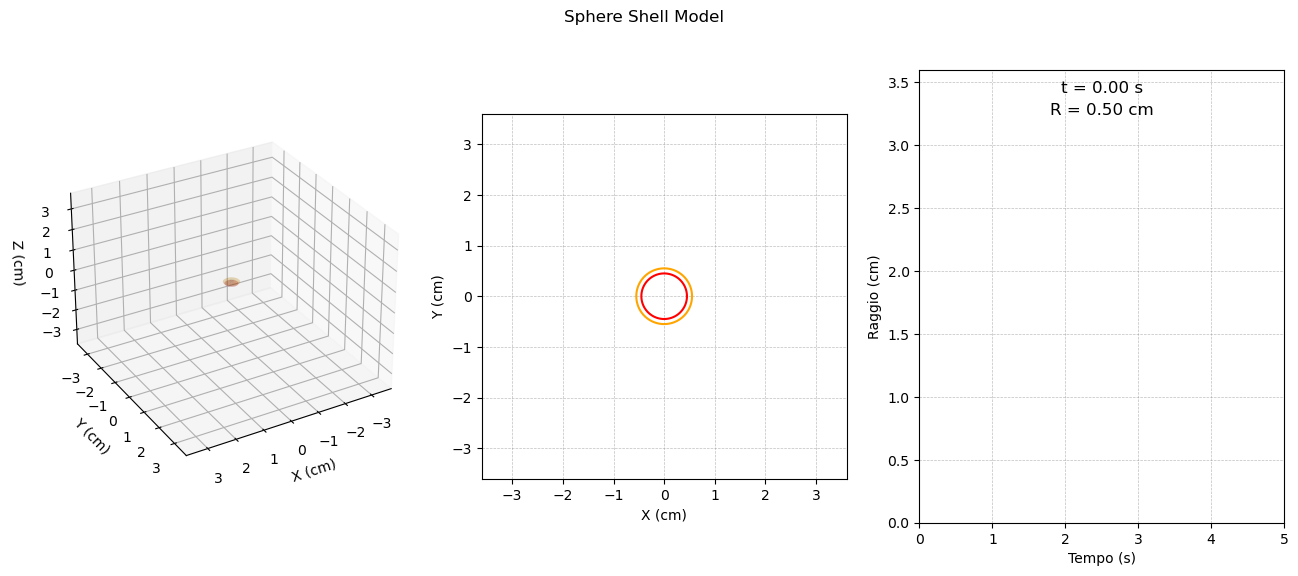

In [86]:
#------------------- temporal constraints -------------------------
t_start = 0
t_end = 5
frames = 50
times = np.linspace(t_start, t_end, frames)
radii = 0.5 + 0.5 * times  # r(t)
#-------------------------------------------------------------------

fig = plt.figure(figsize=(16, 6), dpi=100)
fig.suptitle("Sphere Shell Model")

# 3D subplot
ax3d = fig.add_subplot(131, projection='3d')
ax3d.set_facecolor('white')
ax3d.view_init(elev=20, azim=60)

# 2D subplot per sezioni
ax2d = fig.add_subplot(132)
ax2d.set_aspect('equal')

# 2D subplot per grafico raggio vs tempo
ax1d = fig.add_subplot(133)
ax1d.set_xlim([t_start, t_end])
ax1d.set_ylim([0, max(radii)*1.2])
ax1d.set_xlabel("Tempo (s)")
ax1d.set_ylabel("Raggio (cm)")

# Limiti comuni per i grafici
limit = max(radii) * 1.2
for ax in [ax3d, ax2d]:
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
if hasattr(ax3d, "set_zlim"):  # just in case
    ax3d.set_zlim(-limit, limit)

# Precompute sfera
u = np.linspace(0, 2 * np.pi, 60)
v = np.linspace(0, np.pi, 30)
U, V = np.meshgrid(u, v)
X = np.cos(U) * np.sin(V)
Y = np.sin(U) * np.sin(V)
Z = np.cos(V)

###########################

sigma=30
alpha = np.deg2rad(sigma)    # Apertura angolare (in radianti)

# Risoluzione
n_theta = 20
n_phi = 50

# Griglia angoli
theta = np.linspace(0, alpha, n_theta)
phi = np.linspace(0, 2 * np.pi, n_phi)
theta, phi = np.meshgrid(theta, phi)

# Calotta interna
X=  np.sin(theta) * np.cos(phi)
Y =  np.sin(theta) * np.sin(phi)
Z =  np.cos(theta)


###########################

# Griglie polar coordinate per sezioni
theta = np.linspace(0, 2 * np.pi, 100)
grid_r = np.linspace(0, 1.0, 5)

# Cerchi iniziali sezioni
circle_xy, = ax2d.plot([], [], 'r', lw=2, label='XY (Z=0)')
circle_xz, = ax2d.plot([], [], 'b--', lw=1, label='XZ (Y=0)')
circle_yz, = ax2d.plot([], [], 'g--', lw=1, label='YZ (X=0)')

# Linea per il grafico del raggio
line_raggio, = ax1d.plot([], [], color='blue', lw=2)

# Variabili globali per il testo
time_text = None
radius_text = None

# Funzione di aggiornamento
def update(frame):
    global time_text, radius_text
    
    r = radii[frame]
    delta_r = 0.2 * r  # ad esempio 20% dello spessore
    r_in = r - delta_r / 2
    r_out = r + delta_r / 2

    # === Shell 3D ===
    ax3d.cla()
    ax3d.set_xlim(-limit, limit)
    ax3d.set_ylim(-limit, limit)
    ax3d.set_zlim(-limit, limit)
    ax3d.view_init(elev=30, azim=60)
    #ax3d.text2D(0.05, 0.95, f"t = {times[frame]:.2f} s", transform=ax3d.transAxes)
    #ax3d.text2D(0.05, 0.90, f"R = {r:.2f} cm", transform=ax3d.transAxes)
    ax3d.set_xlabel("X (cm)")
    ax3d.set_ylabel("Y (cm)")
    ax3d.set_zlabel("Z (cm)")

    # Superfici interna ed esterna della shell
    ax3d.plot_surface(r_in * X, r_in * Y, r_in * Z, color='red', alpha=0.3, edgecolor='none')
    ax3d.plot_surface(r_out * X, r_out * Y, r_out * Z, color='orange', alpha=0.3, edgecolor='none')

    # === Sezione 2D ===
    ax2d.cla()
    ax2d.set_xlim(-limit, limit)
    ax2d.set_ylim(-limit, limit)
    ax2d.set_aspect('equal')
    ax2d.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax2d.set_xlabel("X (cm)")
    ax2d.set_ylabel("Y (cm)")

    # Due cerchi concentrici per la shell
    ax2d.plot(r_in * np.cos(theta), r_in * np.sin(theta), 'r', lw=1.5, label='Shell Inner')
    ax2d.plot(r_out * np.cos(theta), r_out * np.sin(theta), 'orange', lw=1.5, label='Shell Outer')

    # === Grafico raggio vs tempo ===
    line_raggio.set_data(times[:frame+1], radii[:frame+1])

    # Rimuovere il testo precedente, se esiste
    if time_text is not None:
        time_text.remove()
    if radius_text is not None:
        radius_text.remove()

    # Aggiungere il nuovo testo nel grafico raggio vs tempo
    time_text = ax1d.text(0.5, 0.95, f't = {times[frame]:.2f} s', transform=ax1d.transAxes, ha='center', fontsize=12, color='black')
    radius_text = ax1d.text(0.5, 0.90, f'R = {r:.2f} cm', transform=ax1d.transAxes, ha='center', fontsize=12, color='black')
    ax1d.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    
    return [line_raggio]

# Crea animazione
ani = FuncAnimation(fig, update, frames=frames, blit=False)
ani.save("espansione_cono_con_sezioni_e_raggio1.gif", writer=PillowWriter(fps=10))

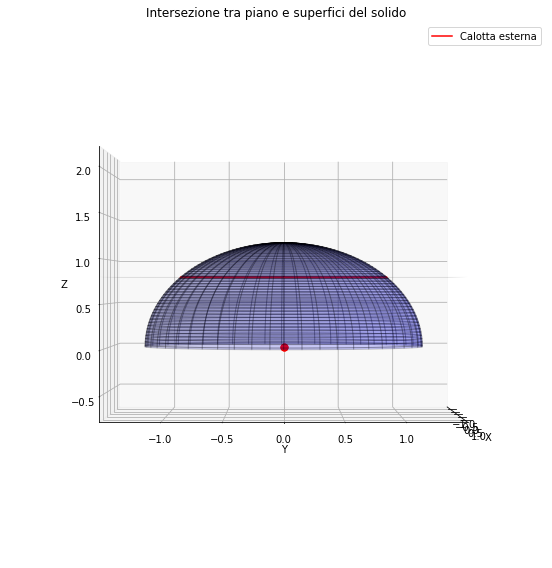

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import brentq

def set_axes_equal(ax):
    '''Set 3D plot axes to equal scale (proportional units in all directions).'''
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # Il range massimo determina il box
    plot_radius = 0.5 * max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
    

    
# Parametri del solido
R = 1.2
alpha_deg = 90
alpha = np.deg2rad(alpha_deg)
limit = R* 1.2

# Coordinate sferiche
phi = np.linspace(0, 2 * np.pi, 200)
theta = np.linspace(0, alpha, 100)
phi, theta = np.meshgrid(phi, theta)


# Conversione in coordinate cartesiane
X = np.sin(theta) * np.cos(phi)
Y = np.sin(theta) * np.sin(phi)
Z = np.cos(theta)

h = 0.8  # Altezza del piano
theta_plane_deg =0  # Inclinazione rispetto all'asse z
phi_plane_deg = 0  # Angolo di direzione rispetto all'asse x


def plane(h,theta_plane_deg,phi_plane_deg):

    theta_plane = np.deg2rad(theta_plane_deg)
    phi_plane = np.deg2rad(phi_plane_deg)

    a = np.sin(theta_plane) * np.cos(phi_plane)
    b = np.sin(theta_plane) * np.sin(phi_plane)
    c = np.cos(theta_plane)
    d = -h * c
    
    return a,b,c,d
    

def intersect_spherical_cap(R,a,b,c,d):
    phi_vals = np.linspace(0, 2 * np.pi, 400)
    points = []

    for phi in phi_vals:
        A = a * np.cos(phi) + b * np.sin(phi)
        B = c
        D = d / R

        def f(theta):
            return A * np.sin(theta) + B * np.cos(theta) + D

        try:
            theta_root = brentq(f, 1e-6, np.pi - 1e-6)  # cerchiamo su tutta la sfera
            # Controlliamo se il punto è sulla superficie visibile della calotta
            if theta_root <= alpha:
                x = R * np.sin(theta_root) * np.cos(phi)
                y = R * np.sin(theta_root) * np.sin(phi)
                z = R * np.cos(theta_root)
                points.append([x, y, z])
        except ValueError:
            continue

    return np.array(points)


plane1=plane(h,theta_plane_deg,phi_plane_deg)
a=plane1[0]
b=plane1[1]
c=plane1[2]
d=plane1[3]
curve_outer = intersect_spherical_cap(R,a,b,c,d)


# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.plot_surface(R*X, R*Y,R* Z, color='blue', alpha=0.2, edgecolor='k')


if len(curve_outer):
    ax.plot(curve_outer[:, 0], curve_outer[:, 1], curve_outer[:, 2], label='Calotta esterna', color='red')


# Piano di taglio per riferimento visivo
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 10), np.linspace(-1.5, 1.5, 10))
zz = (-a * xx - b* yy - d) / c
ax.plot_surface(xx, yy, zz, alpha=0.2, color='gray')
ax.scatter(0, 0, 0, color='red', s=50)
ax.set_xlim([-limit, limit])
ax.set_ylim([-limit, limit])
ax.set_zlim([0, limit])
set_axes_equal(ax)

# Vista fissa
ax.view_init(elev=00, azim=0)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Intersezione tra piano e superfici del solido")
ax.legend()
# Aggiungi un punto rosso all'origine
ax.scatter(0, 0, 0, color='red', s=50)

plt.tight_layout()
plt.show()




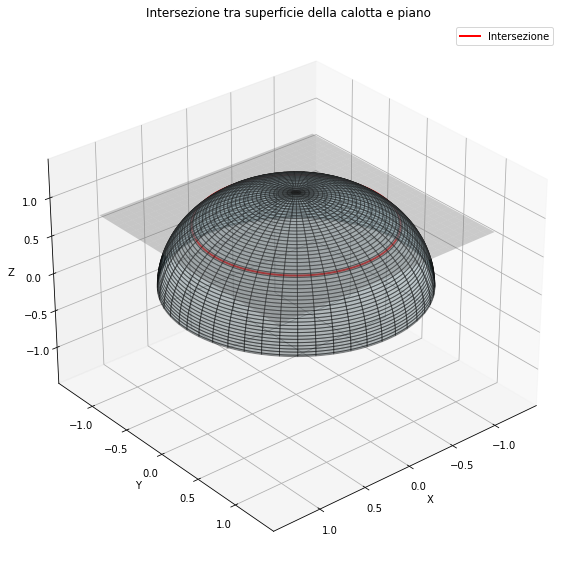

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from mpl_toolkits.mplot3d import Axes3D

# Parametri
R = 1.2
limit = R* 1.2
alpha_deg = 90
alpha = np.deg2rad(alpha_deg)

# Coefficienti del piano: ax + by + cz + d = 0
a, b, c, d = 0, 0, 1, -0.8  # Esempio: piano y + z = 1.05

# Funzione che calcola l'intersezione tra calotta e piano
def intersect_spherical_cap(R, alpha, a, b, c, d, num_phi=400, eps=1e-3):
    phi_vals = np.linspace(0, 2*np.pi, num_phi)
    points = []

    for phi in phi_vals:
        def f(theta):
            x = R * np.sin(theta) * np.cos(phi)
            y = R * np.sin(theta) * np.sin(phi)
            z = R * np.cos(theta)
            return a * x + b * y + c * z + d

        try:
            if f(0) * f(alpha) < 0:
                theta_root = brentq(f, 0, alpha)
                if theta_root < alpha - eps:
                    x = R * np.sin(theta_root) * np.cos(phi)
                    y = R * np.sin(theta_root) * np.sin(phi)
                    z = R * np.cos(theta_root)
                    points.append([x, y, z])
        except ValueError:
            continue

    return np.array(points)


# Genera la calotta per il plot
theta = np.linspace(0, alpha, 100)
phi = np.linspace(0, 2*np.pi, 200)
theta, phi = np.meshgrid(theta, phi)
X = R * np.sin(theta) * np.cos(phi)
Y = R * np.sin(theta) * np.sin(phi)
Z = R * np.cos(theta)

# Calcola intersezione
curve = intersect_spherical_cap(R, alpha, a, b, c, d)

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, color='lightblue', alpha=0.4, edgecolor='k')


if len(curve):
    ax.plot(curve[:, 0], curve[:, 1], curve[:, 2], color='red', lw=2, label='Intersezione')

# Plot del piano (solo per riferimento visivo)
xx, yy = np.meshgrid(np.linspace(-R, R, 30), np.linspace(-R, R, 30))
zz = (-a * xx - b * yy - d) / c
ax.plot_surface(xx, yy, zz, alpha=0.3, color='gray')

ax.view_init(elev=30, azim=50)
# Impostazioni grafiche
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim([-limit, limit])
ax.set_ylim([-limit, limit])
ax.set_zlim([-limit, limit])

ax.set_title("Intersezione tra superficie della calotta e piano")
ax.legend()
plt.tight_layout()
plt.show()


## ----------------------------------------- ANIMATIONS ------------------------------------------


In [145]:
def plane(h,theta_plane_deg,phi_plane_deg):

    theta_plane = np.deg2rad(theta_plane_deg)
    phi_plane = np.deg2rad(phi_plane_deg)

    a = np.sin(theta_plane) * np.cos(phi_plane)
    b = np.sin(theta_plane) * np.sin(phi_plane)
    c = np.cos(theta_plane)
    d = -(a * 0 + b * 0 + c * h)
    
    return a,b,c,d

def generate_inclined_plane_grid(z0, theta_deg, phi_deg, size=1.5, density=20):

    theta = np.deg2rad(theta_deg)
    phi = np.deg2rad(phi_deg)

    # Normale al piano (vettore diretto)
    nx = np.sin(theta) * np.cos(phi)
    ny = np.sin(theta) * np.sin(phi)
    nz = np.cos(theta)

    # Punto sul piano
    p0 = np.array([0, 0, z0])

    # Trova due vettori ortogonali alla normale per generare il piano
    # Primo vettore arbitrario non parallelo alla normale
    if abs(nx) < 1e-6 and abs(ny) < 1e-6:
        v1 = np.array([1, 0, 0])
    else:
        v1 = np.array([-ny, nx, 0])
    v1 = v1 / np.linalg.norm(v1)

    # Secondo vettore ortogonale sia alla normale sia a v1
    v2 = np.cross([nx, ny, nz], v1)
    v2 = v2 / np.linalg.norm(v2)

    # Crea griglia nei parametri u e v
    u = np.linspace(-size, size, density)
    v = np.linspace(-size, size, density)
    uu, vv = np.meshgrid(u, v)

    # Coordinate del piano
    X = p0[0] + uu * v1[0] + vv * v2[0]
    Y = p0[1] + uu * v1[1] + vv * v2[1]
    Z = p0[2] + uu * v1[2] + vv * v2[2]

    return X, Y, Z


def intersect_spherical_cap(R,a,b,c,d):
    phi_vals = np.linspace(0, 2 * np.pi, 400)
    points = []

    for phi in phi_vals:
        A = a * np.cos(phi) + b * np.sin(phi)
        B = c
        D = d / R

        def f(theta):
            return A * np.sin(theta) + B * np.cos(theta) + D

        try:
            theta_root = brentq(f, 1e-6, np.pi - 1e-6)  # cerchiamo su tutta la sfera
            # Controlliamo se il punto è sulla superficie visibile della calotta
            if theta_root <= alpha:
                x = R * np.sin(theta_root) * np.cos(phi)
                y = R * np.sin(theta_root) * np.sin(phi)
                z = R * np.cos(theta_root)
                points.append([x, y, z])
        except ValueError:
            continue

    return np.array(points)

def lateral_surface(R1,R2):

    phi_wall = np.linspace(0, 2*np.pi, 100)
    r_wall = np.array([R1, R2])
    phi_wall, r_wall = np.meshgrid(phi_wall, r_wall)
    Xw = r_wall * np.sin(alpha) * np.cos(phi_wall)
    Yw = r_wall * np.sin(alpha) * np.sin(phi_wall)
    Zw = r_wall * np.cos(alpha)
    
    return Xw,Yw,Zw

def intersect_lateral_surface(R1, R2, a, b, c, d, alpha, n_phi=400):
    phi_vals = np.linspace(0, 2 * np.pi, n_phi)
    points = []

    for phi in phi_vals:
        sin_alpha = np.sin(alpha)
        cos_alpha = np.cos(alpha)

        A = a * sin_alpha * np.cos(phi) + b * sin_alpha * np.sin(phi) + c * cos_alpha
        if abs(A) < 1e-8:
            continue  # il piano è parallelo alla generatrice

        def f(r):
            return A * r + d

        try:
            r_root = brentq(f, R1, R2)
            x = r_root * sin_alpha * np.cos(phi)
            y = r_root * sin_alpha * np.sin(phi)
            z = r_root * cos_alpha
            points.append([x, y, z])
        except ValueError:
            continue

    return np.array(points)



"""def intersect_lateral_surface(R1, R2, a, b, c, d, alpha, n_phi=400):
    phi_vals = np.linspace(0, 2 * np.pi, n_phi)
    points = []
    sin_alpha = np.sin(alpha)
    cos_alpha = np.cos(alpha)

    for phi in phi_vals:
        A = a * sin_alpha * np.cos(phi) + b * sin_alpha * np.sin(phi) + c * cos_alpha
        if np.abs(A) < 1e-6:
            continue  # Piano quasi parallelo alla direzione

        def f(r):
            return A * r + d

        f1 = f(R1)
        f2 = f(R2)
        if f1 * f2 > 0:
            continue  # Nessuna intersezione in questo intervallo

        try:
            r_root = brentq(f, R1, R2)
            x = r_root * sin_alpha * np.cos(phi)
            y = r_root * sin_alpha * np.sin(phi)
            z = r_root * cos_alpha
            points.append([x, y, z])
        except ValueError:
            continue

    return np.array(points)"""

    

'def intersect_lateral_surface(R1, R2, a, b, c, d, alpha, n_phi=400):\n    phi_vals = np.linspace(0, 2 * np.pi, n_phi)\n    points = []\n    sin_alpha = np.sin(alpha)\n    cos_alpha = np.cos(alpha)\n\n    for phi in phi_vals:\n        A = a * sin_alpha * np.cos(phi) + b * sin_alpha * np.sin(phi) + c * cos_alpha\n        if np.abs(A) < 1e-6:\n            continue  # Piano quasi parallelo alla direzione\n\n        def f(r):\n            return A * r + d\n\n        f1 = f(R1)\n        f2 = f(R2)\n        if f1 * f2 > 0:\n            continue  # Nessuna intersezione in questo intervallo\n\n        try:\n            r_root = brentq(f, R1, R2)\n            x = r_root * sin_alpha * np.cos(phi)\n            y = r_root * sin_alpha * np.sin(phi)\n            z = r_root * cos_alpha\n            points.append([x, y, z])\n        except ValueError:\n            continue\n\n    return np.array(points)'

In [ ]:
#--------------------------------------- Temporal constraints --------------------------------------------
t_start = 0
t_end = 5
frames = 50
times = np.linspace(t_start, t_end, frames)
radii = 0.5 + 0.5 * times  # r(t)

#------------------------------------------ Plane and coordinates definition ----------------------------------------------------------------

alpha_deg = 90
alpha = np.deg2rad(alpha_deg)

# Coordinate sferiche
phi = np.linspace(0, 2 * np.pi, 200)
theta = np.linspace(0, alpha, 100)
phi, theta = np.meshgrid(phi, theta)


# Conversione in coordinate cartesiane
X = np.sin(theta) * np.cos(phi)
Y = np.sin(theta) * np.sin(phi)
Z = np.cos(theta)

h = 1.0  # Altezza del piano
theta_plane_deg =0  # Inclinazione rispetto all'asse z
phi_plane_deg = 0  # Angolo di direzione rispetto all'asse x


plane1=plane(h,theta_plane_deg,phi_plane_deg)
a=plane1[0]
b=plane1[1]
c=plane1[2]
d=plane1[3]

#------------------------------------------------------------------------------------------------------------

fig = plt.figure(figsize=(20, 8), dpi=200)
fig.suptitle("Sphere Shell Model")

#------------------------------------------------- 3D subplot ------------------------------------------------
ax3d = fig.add_subplot(131, projection='3d')

# Ogni valore va da 0 a 1 (percentuale della figura)
#ax1d= fig.add_axes([0.7, 0.15, 0.3, 0.7])  # [x, y, width, height]
#ax2d = fig.add_axes([0.4, 0.15, 0.3, 0.7])
#ax3d = fig.add_axes([0.05, 0.15, 0.35, 0.7], projection='3d')  # anche 3D funziona

ax3d.set_facecolor('white')
ax3d.view_init(elev=20, azim=60)
ax3d.set_xlabel("X (cm)")
ax3d.set_ylabel("Y (cm)")
ax3d.set_zlabel("Z (cm)")

# 2D subplot per sezioni
ax2d = fig.add_subplot(132)
ax2d.set_aspect('equal')

# 1D subplot per grafico raggio vs tempo
#ax1d.set_aspect('equal')
ax1d = fig.add_subplot(133)
ax1d.set_xlim([t_start, t_end])
ax1d.set_ylim([0, max(radii)*1.2])
ax1d.set_xlabel("Tempo (s)")
ax1d.set_ylabel("Raggio (cm)")

# Limiti comuni per i grafici
limit = max(radii) * 1.2
for ax in [ax3d, ax2d]:
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    
if hasattr(ax3d, "set_zlim"):  # just in case
    ax3d.set_zlim(0, limit)

#-----------------------------------------------------------------------------------------------

# Linea per il grafico del raggio
line_raggio, = ax1d.plot([], [], color='blue', lw=2)
#-----------------------------------------------------------------------------------------------

# Variabili globali per il testo
time_text = None
radius_text = None

# Funzione di aggiornamento
def update(frame):
    global time_text, radius_text
    
    r = radii[frame]
    delta_r = 0.2 * r  # ad esempio 20% dello spessore
    r_in = r  #- delta_r / 2
    #r_out = r + delta_r / 2

    # ============================== Shell 3D ==========================================
    ax3d.clear()
    

    ax3d.set_xlim(-limit, limit)
    ax3d.set_ylim(-limit, limit)
    ax3d.set_zlim(0, limit)
    #set_axes_equal(ax3d)
    ax3d.set_box_aspect([2, 2, 1])
    #ax3d.text2D(0.05, 0.95, f"t = {times[frame]:.2f} s", transform=ax3d.transAxes)
    #ax3d.text2D(0.05, 0.90, f"R = {r:.2f} cm", transform=ax3d.transAxes)
    
    #ax3d.view_init(elev=30, azim=30)
    ax3d.set_xlabel("X (cm)")
    ax3d.set_ylabel("Y (cm)")
    ax3d.set_zlabel("Z (cm)")


    # Superfici interna ed esterna della shell
    ax3d.plot_surface(r_in * X, r_in * Y, r_in * Z, color='blue', alpha=0.2, edgecolor='k')
    #ax3d.plot_surface(r_out * X, r_out * Y, r_out * Z, color='orange', alpha=0.3, edgecolor='none')
    
    curve_outer = intersect_spherical_cap(r,a,b,c,d)


    if len(curve_outer):
        ax3d.plot(curve_outer[:, 0], curve_outer[:, 1], curve_outer[:, 2], label='Calotta esterna', color='red')

    # Piano di taglio per riferimento visivo
    #xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 10), np.linspace(-1.5, 1.5, 10))
    xx, yy = np.meshgrid(np.linspace(-limit, limit, 10), np.linspace(-limit, limit, 10))


    zz = (-a * xx - b* yy - d) / c
    ax3d.plot_surface(xx, yy, zz, alpha=0.2, color='gray')
    ax3d.scatter(0, 0, 0, color='red', s=50)
    # ========================== Sezione 2D ==========================
    ax2d.clear()
    ax2d.set_xlim(-limit, limit)
    ax2d.set_ylim(-limit, limit)
    ax2d.set_aspect('equal')
    ax2d.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax2d.set_xlabel("X (cm)")
    ax2d.set_ylabel("Y (cm)")

        # Proiezione 2D della curva di intersezione
    if len(curve_outer):
        curve_proj = curve_outer[:, :2]  # prende solo X e Y
        ax2d.plot(curve_proj[:, 0], curve_proj[:, 1], color='red', linewidth=2, label='Sezione 2D')
        ax2d.legend()

    # ========================= Grafico raggio vs tempo ============================================
    #ax1d.set_box_aspect([1,1])
    line_raggio.set_data(times[:frame+1], radii[:frame+1])

    # Rimuovere il testo precedente, se esiste
    if time_text is not None:
        time_text.remove()
    if radius_text is not None:
        radius_text.remove()

    # Aggiungere il nuovo testo nel grafico raggio vs tempo
    time_text = ax1d.text(0.5, 0.95, f't = {times[frame]:.2f} s', transform=ax1d.transAxes, ha='center', fontsize=12, color='black')
    radius_text = ax1d.text(0.5, 0.90, f'R = {r:.2f} cm', transform=ax1d.transAxes, ha='center', fontsize=12, color='black')
    ax1d.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax1d.set_aspect(1.5)
    return [line_raggio]


# Crea animazione
ani = FuncAnimation(fig, update, frames=frames, blit=False)
ani.save("espansione_cono_con_sezioni_e_raggio.gif", writer=PillowWriter(fps=10))

IndexError: tuple index out of range

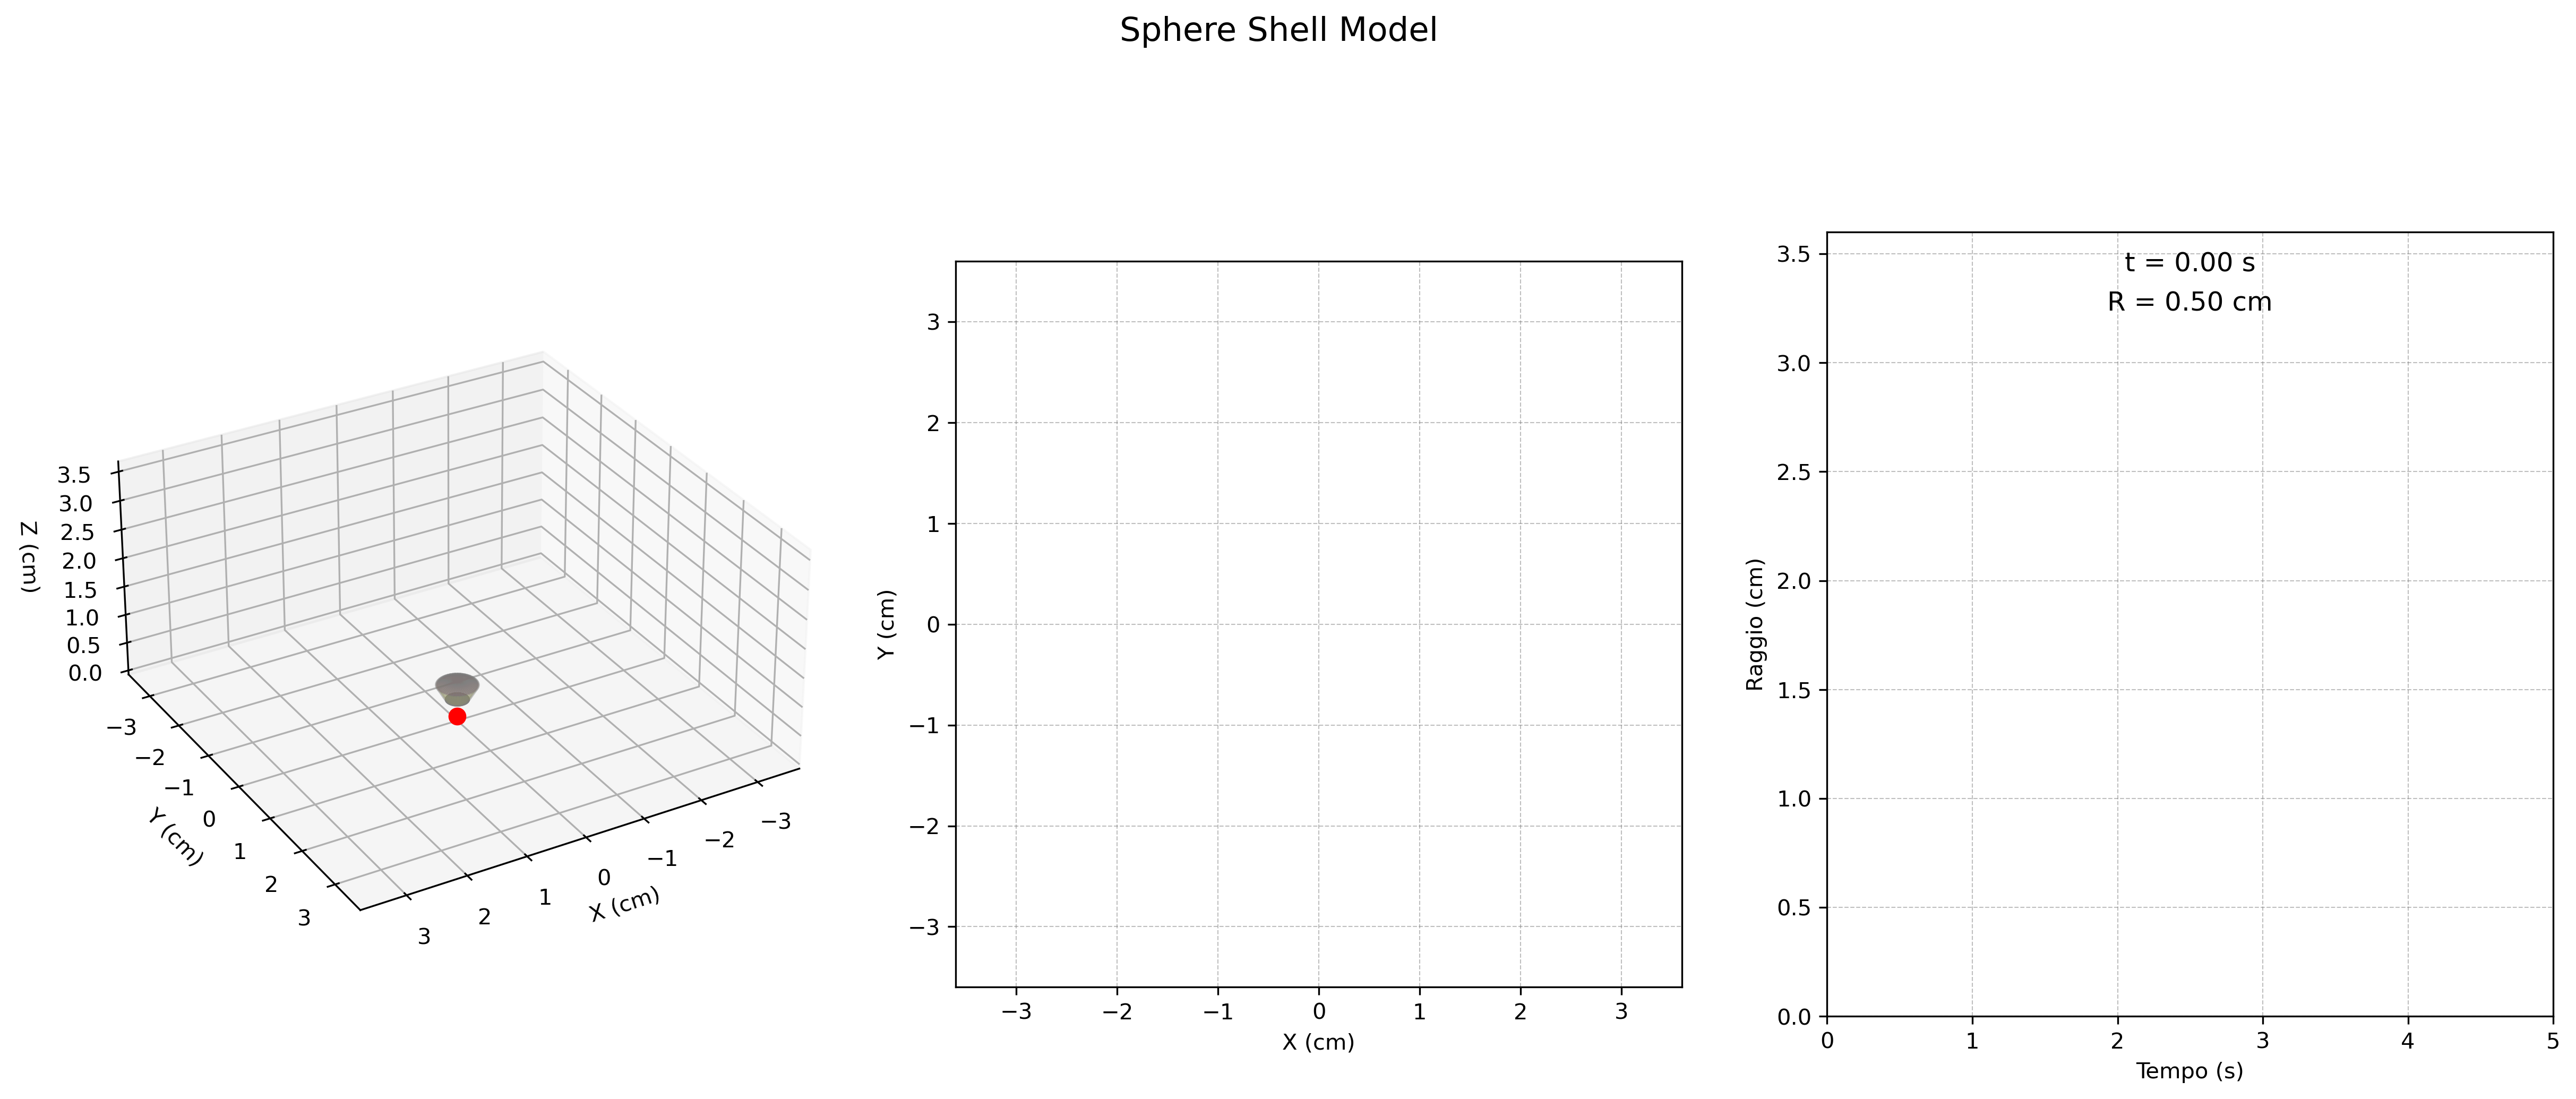

In [138]:
#--------------------------------------- Temporal constraints ------------------------------------------------------------------------------
t_start = 0
t_end = 5
frames = 50
times = np.linspace(t_start, t_end, frames)
radii = 0.5 + 0.5 * times  # r(t)

#------------------------------------------ Plane and coordinates definition ----------------------------------------------------------------

alpha_deg = 30
alpha = np.deg2rad(alpha_deg)

# Coordinate sferiche
phi = np.linspace(0, 2 * np.pi, 200)
theta = np.linspace(0, alpha, 100)
phi, theta = np.meshgrid(phi, theta)


# Conversione in coordinate cartesiane
X = np.sin(theta) * np.cos(phi)
Y = np.sin(theta) * np.sin(phi)
Z = np.cos(theta)

h = 1.0  # Altezza del piano
theta_plane_deg =90  # Inclinazione rispetto all'asse z
phi_plane_deg = 0  # Angolo di direzione rispetto all'asse x

plane1=plane(h,theta_plane_deg,phi_plane_deg)
a=plane1[0]
b=plane1[1]
c=plane1[2]
d=plane1[3]

#------------------------------------------------------------------------------------------------------------

fig = plt.figure(figsize=(20, 8), dpi=300)
fig.suptitle("Sphere Shell Model",fontsize=15)

#------------------------------------------------- 3D subplot ------------------------------------------------
ax3d = fig.add_subplot(131, projection='3d')

# Ogni valore va da 0 a 1 (percentuale della figura)
#ax1d= fig.add_axes([0.7, 0.15, 0.3, 0.7])  # [x, y, width, height]
#ax2d = fig.add_axes([0.4, 0.15, 0.3, 0.7])
#ax3d = fig.add_axes([0.05, 0.15, 0.35, 0.7], projection='3d')  # anche 3D funziona

ax3d.set_facecolor('white')
ax3d.view_init(elev=30, azim=60)
ax3d.set_xlabel("X (cm)")
ax3d.set_ylabel("Y (cm)")
ax3d.set_zlabel("Z (cm)")
ax3d.set_box_aspect([2, 2, 1])

shell_surface1 = [ax3d.plot_surface(X, Y, Z, color='blue', alpha=0.2)]
shell_surface2 = [ax3d.plot_surface(X, Y, Z, color='red', alpha=0.2)]

Xw, Yw, Zw = lateral_surface(1, 1)
lateral_surface_plot = [ax3d.plot_surface(Xw, Yw, Zw, color='gray', alpha=0.3, edgecolor='k')]

xx, yy = np.meshgrid(np.linspace(-limit, limit, 10), np.linspace(-limit, limit, 10))
zz = (-a * xx - b* yy - d) / c
ax3d.plot_surface(xx, yy, zz, alpha=0.2, color='gray')
ax3d.scatter(0, 0, 0, color='red', s=50)

intersection_out = [None] 
intersection_in = [None] 
lateral=[None]
lateral3D=[None]

#------------------------------------------------- 2D subplot ----------------------------------------------
ax2d = fig.add_subplot(132)
ax2d.set_aspect('equal')
ax2d.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax2d.set_xlabel("X (cm)")
ax2d.set_ylabel("Y (cm)")

curve_out = [None] 
curve_in = [None] 
intersection_lat=[None]

#------------------------------------------------- 1D subplot  --------------------------------------------
#ax1d.set_aspect('equal')
ax1d = fig.add_subplot(133)
ax1d.set_xlim([t_start, t_end])
ax1d.set_ylim([0, max(radii)*1.2])
ax1d.set_xlabel("Tempo (s)")
ax1d.set_ylabel("Raggio (cm)")

#-------------------------------------------------  Limits ----------------------------------------------- 
limit = max(radii) * 1.2
for ax in [ax3d, ax2d]:
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    
if hasattr(ax3d, "set_zlim"):  # just in case
    ax3d.set_zlim(0, limit)

ax1d.set_ylim(0,limit)

# Linea per il grafico del raggio

line_raggio, = ax1d.plot([], [], color='blue', lw=2)
#-------------------------------------------------------------------------------------------------------------

# Variabili globali per il testo
time_text = None
radius_text = None

# Funzione di aggiornamento
def update(frame):
    global time_text, radius_text
    
    r = radii[frame]
    delta_r = 0.6 * r  # ad esempio 20% dello spessore
    r_in = r - delta_r / 2
    r_out = r + delta_r / 2

    #---------------------------------------------------- 3D------------------------------------------------------------------
    shell_surface1[0].remove()
    shell_surface2[0].remove()
    
    shell_surface1[0] = ax3d.plot_surface(r_in * X, r_in * Y, r_in * Z, color='blue', alpha=0.5,edgecolor='gray')
    shell_surface2[0] = ax3d.plot_surface(r_out * X, r_out * Y, r_out* Z, color='red', alpha=0.1,edgecolor='gray')
    
    lateral_surface_plot[0].remove()
    Xw, Yw, Zw = lateral_surface(r_out, r_in)
    lateral_surface_plot[0] = ax3d.plot_surface(Xw, Yw, Zw, color='yellow', alpha=0.1, edgecolor='gray')

    #----------------------------------------------------------------------
    if intersection_out[0] is not None:
        for line in intersection_out[0]:  # è una lista
            line.remove()
        intersection_out[0] = None
        
    curve_outer = intersect_spherical_cap(r_out,a,b,c,d)

    if curve_outer is not None and len(curve_outer):
        intersection_out[0]=ax3d.plot(curve_outer[:, 0], curve_outer[:, 1], curve_outer[:, 2], label='Calotta esterna', color='red')
    
    #----------------------------------------------------------------------   
    if intersection_in[0] is not None:
        for line in intersection_in[0]:
            line.remove()
        intersection_in[0] = None
        
    curve_inner = intersect_spherical_cap(r_in,a,b,c,d)
    
    if  curve_inner is not None and len(curve_inner):
        intersection_in[0]=ax3d.plot(curve_inner[:, 0], curve_inner[:, 1], curve_inner[:, 2], label='Calotta inner', color='blue')
        
    if lateral3D[0] is not None:
        for line in lateral3D[0]:  # è una lista
            line.remove()
        lateral3D[0] = None
    
    curve_lateral = intersect_lateral_surface(r_in, r_out, a, b, c, d, alpha)
    
    if  curve_lateral is not None and len(curve_lateral):
        lateral3D[0]=ax3d.plot(curve_lateral[:, 0], curve_lateral[:, 1], curve_lateral[:, 2], label='Calotta inner', color='orange')
    #----------------------------------------- 2D -------------------------------------------------------
    if curve_out[0] is not None:
        for line in curve_out[0]:  # è una lista
            line.remove()
        curve_out[0] = None
        
    if curve_in[0] is not None:
        for line in curve_in[0]:  # è una lista
            line.remove()
        curve_in[0] = None
    
    if curve_outer is not None and len(curve_outer):
        curve_proj_out = curve_outer[:, :2]  # prende solo X e Y
        curve_out[0]=ax2d.plot(curve_proj_out[:, 0], curve_proj_out[:, 1], color='red', linewidth=2, label='Sezione 2D out')
        ax2d.legend()
        
    if curve_inner is not None and len(curve_inner):
        curve_proj_in= curve_inner[:, :2]  # prende solo X e Y
        curve_in[0]=ax2d.plot(curve_proj_in[:, 0], curve_proj_in[:, 1], color='blue', linewidth=2, label='Sezione 2D in')
        ax2d.legend()

    if intersection_lat[0] is not None:
        for line in intersection_lat[0]:  # è una lista
            line.remove()
        intersection_lat[0] = None
        
    if curve_lateral is not None and len(curve_lateral):
        curve_proj_lat= curve_lateral[:, :2]  # prende solo X e Y
        intersection_lat[0]=ax2d.plot(curve_proj_lat[:, 0], curve_proj_lat[:, 1], color='orange', linewidth=2, label='Sezione 2D lat')
        ax2d.legend()
    #----------------------------------------- R(t) vs time ---------------------------------------------
    
    line_raggio.set_data(times[:frame+1], radii[:frame+1])

    # Rimuovere il testo precedente, se esiste
    if time_text is not None:
        time_text.remove()
    if radius_text is not None:
        radius_text.remove()

    # Aggiungere il nuovo testo nel grafico raggio vs tempo
    time_text = ax1d.text(0.5, 0.95, f't = {times[frame]:.2f} s', transform=ax1d.transAxes, ha='center', fontsize=12, color='black')
    radius_text = ax1d.text(0.5, 0.90, f'R = {r:.2f} cm', transform=ax1d.transAxes, ha='center', fontsize=12, color='black')
    ax1d.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax1d.set_aspect(1.5)
    return line_raggio,shell_surface1,shell_surface2,curve_outer,curve_inner,lateral, intersection_lat,lateral3D


# Crea animazione
ani = FuncAnimation(fig, update, frames=frames, blit=False)
ani.save("espansione_cono_con_sezioni_e_raggio_test.gif", writer=PillowWriter(fps=10))

In [147]:
def spherical_sector_mesh(r_in, r_out, alpha_min, alpha_max, n_phi=100, n_theta=50):
    phi = np.linspace(0, 2 * np.pi, n_phi)
    theta_inner = np.linspace(alpha_min, alpha_max, n_theta)
    theta_outer = np.linspace(alpha_min, alpha_max, n_theta)
    phi, theta_inner = np.meshgrid(phi, theta_inner)
    phi, theta_outer = np.meshgrid(phi, theta_outer)

    # Calotte interna ed esterna
    X_inner = r_in * np.sin(theta_inner) * np.cos(phi)
    Y_inner = r_in * np.sin(theta_inner) * np.sin(phi)
    Z_inner = r_in * np.cos(theta_inner)

    X_outer = r_out * np.sin(theta_outer) * np.cos(phi)
    Y_outer = r_out * np.sin(theta_outer) * np.sin(phi)
    Z_outer = r_out * np.cos(theta_outer)

    return (X_inner, Y_inner, Z_inner), (X_outer, Y_outer, Z_outer)


In [148]:
def lateral_ring_surface(r_in, r_out, alpha, n_phi=100):
    phi = np.linspace(0, 2 * np.pi, n_phi)
    r = np.linspace(r_in, r_out, 2)
    phi, r = np.meshgrid(phi, r)

    X = r * np.sin(alpha) * np.cos(phi)
    Y = r * np.sin(alpha) * np.sin(phi)
    Z = r * np.cos(alpha)

    return X, Y, Z


ValueError: operands could not be broadcast together with shapes (50,100) (50,5000) 

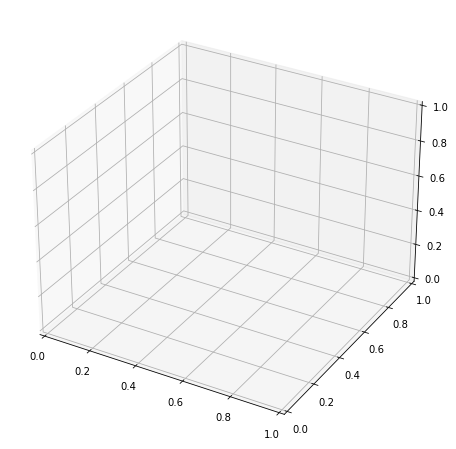

In [149]:
r_in = 1
r_out = 1.2
alpha_min = np.deg2rad(30)
alpha_max = np.deg2rad(60)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Calotte
(inner_x, inner_y, inner_z), (outer_x, outer_y, outer_z) = spherical_sector_mesh(r_in, r_out, alpha_min, alpha_max)
ax.plot_surface(inner_x, inner_y, inner_z, color='blue', alpha=0.5)
ax.plot_surface(outer_x, outer_y, outer_z, color='red', alpha=0.3)

# Superfici laterali
for alpha_edge in [alpha_min, alpha_max]:
    X, Y, Z = lateral_ring_surface(r_in, r_out, alpha_edge)
    ax.plot_surface(X, Y, Z, color='orange', alpha=0.4)

ax.set_box_aspect([1, 1, 1])
ax.set_title("Anello sferico tra due angoli alpha")
plt.show()


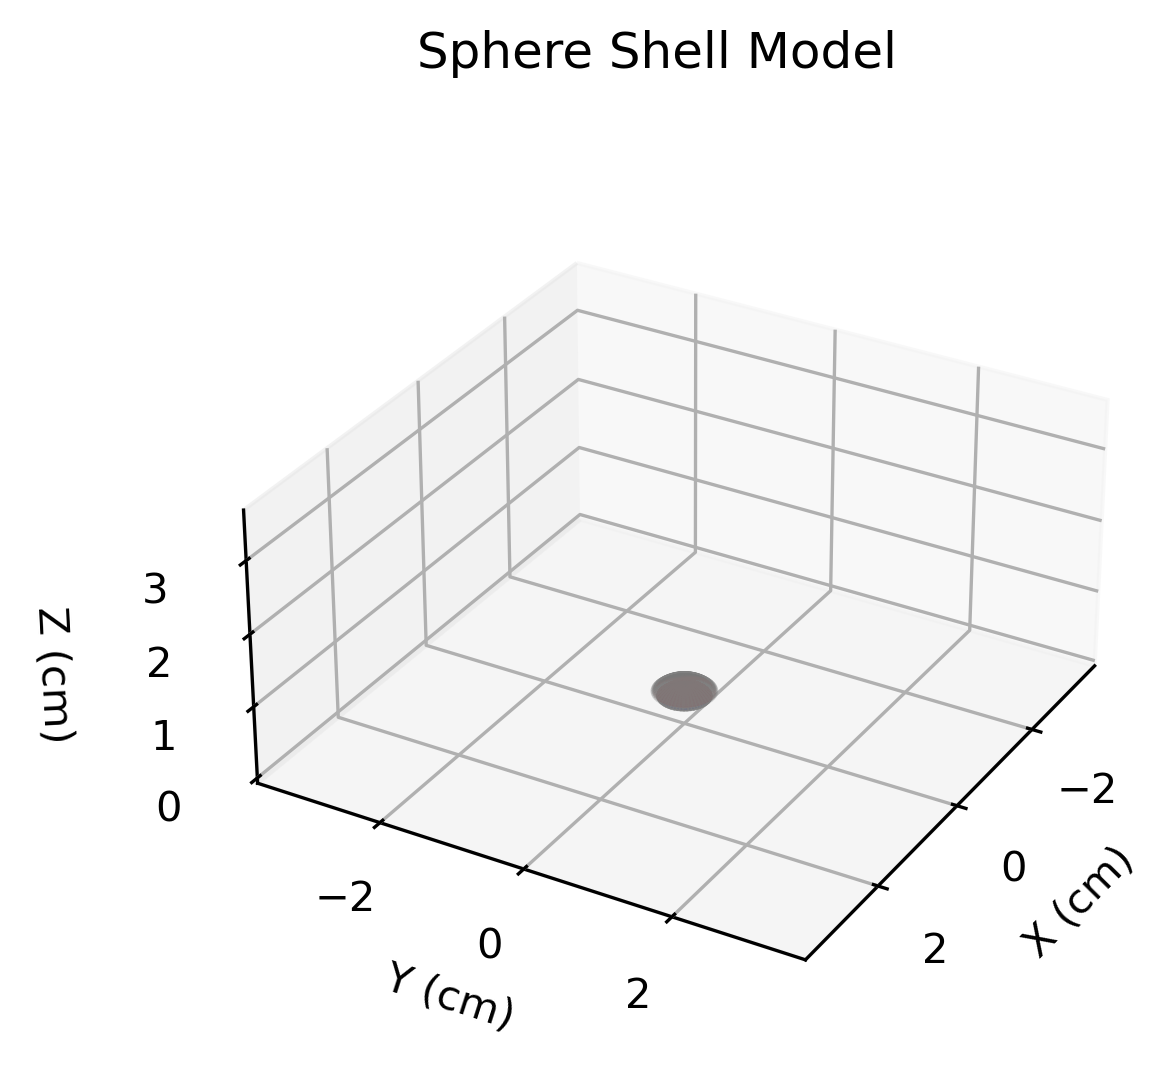

In [ ]:
from matplotlib.animation import FFMpegWriter

#--------------------------------------- Temporal constraints --------------------------------------------
t_start = 0
t_end = 5
frames = 50
times = np.linspace(t_start, t_end, frames)
radii = 0.5 + 0.5 * times  # r(t)

#------------------------------------------ Plane and coordinates definition ----------------------------------------------------------------

alpha_deg = 45
alpha = np.deg2rad(alpha_deg)

# Coordinate sferiche
phi = np.linspace(0, 2 * np.pi, 200)
theta = np.linspace(0, alpha, 100)
phi, theta = np.meshgrid(phi, theta)


# Conversione in coordinate cartesiane
X = np.sin(theta) * np.cos(phi)
Y = np.sin(theta) * np.sin(phi)
Z = np.cos(theta)

h = 1.0  # Altezza del piano
theta_plane_deg =0  # Inclinazione rispetto all'asse z
phi_plane_deg = 0  # Angolo di direzione rispetto all'asse x





plane1=plane(h,theta_plane_deg,phi_plane_deg)
a=plane1[0]
b=plane1[1]
c=plane1[2]
d=plane1[3]

#------------------------------------------------------------------------------------------------------------

fig = plt.figure(figsize=(8, 8), dpi=300)
fig.suptitle("Sphere Shell Model")

#------------------------------------------------- 3D subplot ------------------------------------------------
ax3d = fig.add_subplot(111, projection='3d')

# Ogni valore va da 0 a 1 (percentuale della figura)
#ax1d= fig.add_axes([0.7, 0.15, 0.3, 0.7])  # [x, y, width, height]
#ax2d = fig.add_axes([0.4, 0.15, 0.3, 0.7])
#ax3d = fig.add_axes([0.05, 0.15, 0.35, 0.7], projection='3d')  # anche 3D funziona

ax3d.set_facecolor('white')
ax3d.view_init(elev=30, azim=30)
ax3d.set_xlabel("X (cm)")
ax3d.set_ylabel("Y (cm)")
ax3d.set_zlabel("Z (cm)")
ax3d.set_box_aspect([2, 2, 1])


# Limiti comuni per i grafici
limit = max(radii) * 1.2
for ax in [ax3d]:
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    
if hasattr(ax3d, "set_zlim"):  # just in case
    ax3d.set_zlim(0, limit)

shell_surface1 = [ax3d.plot_surface(X, Y, Z, color='blue', alpha=0.2)]
shell_surface2=  [ax3d.plot_surface(X, Y, Z, color='red', alpha=0.2)]

# Funzione di aggiornamento
def update(frame):
    global time_text, radius_text
    
    r = radii[frame]
    delta_r = 0.2 * r  # ad esempio 20% dello spessore
    r_in = r - delta_r / 2
    r_out = r + delta_r / 2

    # ============================== Shell 3D ==========================================
    #ax3d.clear()
    

    #set_axes_equal(ax3d)
    #ax3d.text2D(0.05, 0.95, f"t = {times[frame]:.2f} s", transform=ax3d.transAxes)
    #ax3d.text2D(0.05, 0.90, f"R = {r:.2f} cm", transform=ax3d.transAxes)
    
    shell_surface1[0].remove()
    shell_surface2[0].remove()
    # Ridisegna quella nuova e la salva
    shell_surface1[0] = ax3d.plot_surface(r_in * X, r_in * Y, r_in * Z, color='blue', alpha=0.5,edgecolor='gray')
    shell_surface2[0] = ax3d.plot_surface(r_out * X, r_out * Y, r_out* Z, color='red', alpha=0.1,edgecolor='gray')
    
    # Superfici interna ed esterna della shell
    #ax3d.plot_surface(r_in * X, r_in * Y, r_in * Z, color='blue', alpha=0.2, edgecolor='k')
    #ax3d.plot_surface(r_out * X, r_out * Y, r_out * Z, color='orange', alpha=0.3, edgecolor='none')
    return shell_surface1,shell_surface2
   


# Crea animazione
ani = FuncAnimation(fig, update, frames=frames, blit=False)
ani.save("espansione_test.gif", writer=PillowWriter(fps=10))


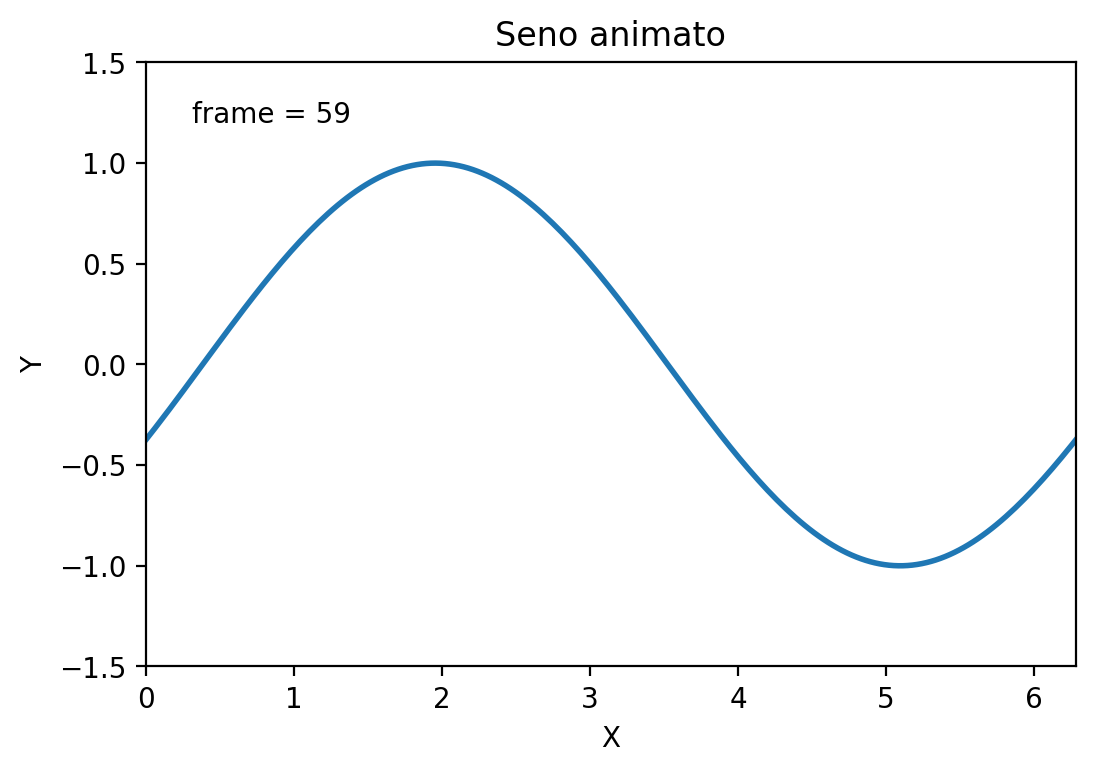

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Setup
x = np.linspace(0, 2*np.pi, 200)
y = np.sin(x)

fig, ax = plt.subplots(dpi=200)
line, = ax.plot(x, y, lw=2)

# Etichette fisse
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Seno animato")

# Elemento testuale dinamico
text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

# Funzione di aggiornamento
def update(frame):
    y = np.sin(x + 0.1 * frame)
    line.set_ydata(y)
    text.set_text(f"frame = {frame}")
    return line, text

ani = FuncAnimation(fig, update, frames=60, interval=100, blit=True)

# Salva la GIF senza artefatti
ani.save("seno.gif", writer=PillowWriter(fps=10))



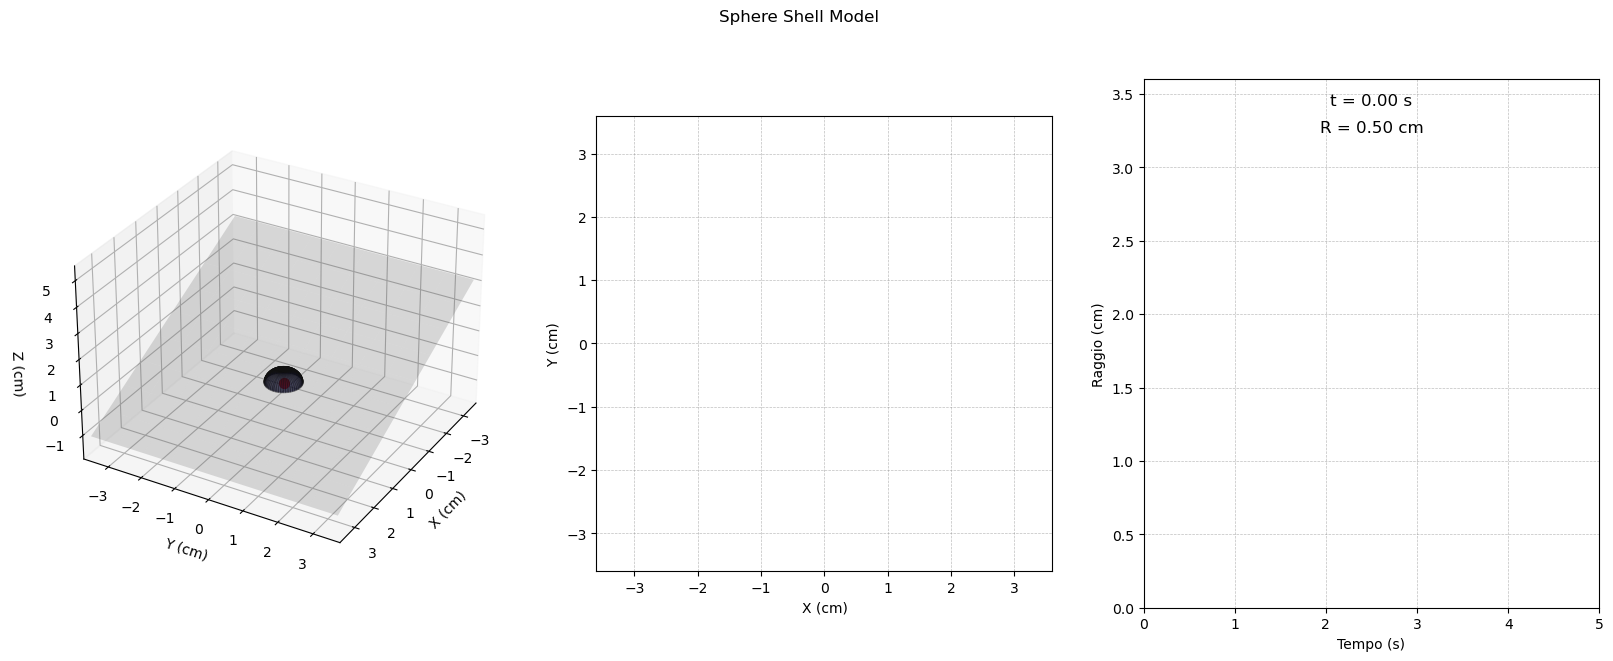

In [32]:
#------------------- temporal constraints -------------------------
t_start = 0
t_end = 5
frames = 50
times = np.linspace(t_start, t_end, frames)
radii = 0.5 + 0.5 * times  # r(t)
#-------------------------------------------------------------------

fig = plt.figure(figsize=(20, 7), dpi=100)
fig.suptitle("Sphere Shell Model")

# 3D subplot
ax3d = fig.add_subplot(131, projection='3d')

# Ogni valore va da 0 a 1 (percentuale della figura)
#ax_raggio = fig.add_axes([0.65, 0.15, 0.3, 0.7])  # [x, y, width, height]
#ax2d = fig.add_axes([0.35, 0.15, 0.25, 0.7])
#ax3d = fig.add_axes([0.05, 0.15, 0.25, 0.7], projection='3d')  # anche 3D funziona

ax3d.set_facecolor('white')
ax3d.view_init(elev=20, azim=60)

# 2D subplot per sezioni
ax2d = fig.add_subplot(132)
ax2d.set_aspect('equal')

# 1D subplot per grafico raggio vs tempo
ax1d = fig.add_subplot(133)
ax1d.set_xlim([t_start, t_end])
ax1d.set_ylim([0, max(radii)*1.2])
ax1d.set_xlabel("Tempo (s)")
ax1d.set_ylabel("Raggio (cm)")

# Limiti comuni per i grafici
limit = max(radii) * 1.2
for ax in [ax3d, ax2d]:
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    
if hasattr(ax3d, "set_zlim"):  # just in case
    ax3d.set_zlim(0, limit)

#-----------------------------------------------------------------------------------------------

alpha_deg = 90
alpha = np.deg2rad(alpha_deg)

# Coordinate sferiche
phi = np.linspace(0, 2 * np.pi, 200)
theta = np.linspace(0, alpha, 100)
phi, theta = np.meshgrid(phi, theta)


# Conversione in coordinate cartesiane
X = np.sin(theta) * np.cos(phi)
Y = np.sin(theta) * np.sin(phi)
Z = np.cos(theta)

h = 1.0  # Altezza del piano
theta_plane_deg =30  # Inclinazione rispetto all'asse z
phi_plane_deg = 0  # Angolo di direzione rispetto all'asse x


def plane(h,theta_plane_deg,phi_plane_deg):

    theta_plane = np.deg2rad(theta_plane_deg)
    phi_plane = np.deg2rad(phi_plane_deg)

    a = np.sin(theta_plane) * np.cos(phi_plane)
    b = np.sin(theta_plane) * np.sin(phi_plane)
    c = np.cos(theta_plane)
    d = -h * c
    
    return a,b,c,d
    

def intersect_spherical_cap(R,a,b,c,d):
    phi_vals = np.linspace(0, 2 * np.pi, 400)
    points = []

    for phi in phi_vals:
        A = a * np.cos(phi) + b * np.sin(phi)
        B = c
        D = d / R

        def f(theta):
            return A * np.sin(theta) + B * np.cos(theta) + D

        try:
            theta_root = brentq(f, 1e-6, np.pi - 1e-6)  # cerchiamo su tutta la sfera
            # Controlliamo se il punto è sulla superficie visibile della calotta
            if theta_root <= alpha:
                x = R * np.sin(theta_root) * np.cos(phi)
                y = R * np.sin(theta_root) * np.sin(phi)
                z = R * np.cos(theta_root)
                points.append([x, y, z])
        except ValueError:
            continue

    return np.array(points)


plane1=plane(h,theta_plane_deg,phi_plane_deg)
a=plane1[0]
b=plane1[1]
c=plane1[2]
d=plane1[3]

#-----------------------------------------------------------------------------------------------
# Linea per il grafico del raggio
line_raggio, = ax1d.plot([], [], color='blue', lw=2)
#-----------------------------------------------------------------------------------------------

# Variabili globali per il testo
time_text = None
radius_text = None

# Funzione di aggiornamento
def update(frame):
    global time_text, radius_text
    
    r = radii[frame]
    delta_r = 0.2 * r  # ad esempio 20% dello spessore
    r_in = r  #- delta_r / 2
    #r_out = r + delta_r / 2

    # ============================== Shell 3D ==========================================
    ax3d.cla()
    ax3d.set_xlim(-limit, limit)
    ax3d.set_ylim(-limit, limit)
    ax3d.set_zlim(0, limit)
    set_axes_equal(ax3d)
    #ax3d.text2D(0.05, 0.95, f"t = {times[frame]:.2f} s", transform=ax3d.transAxes)
    #ax3d.text2D(0.05, 0.90, f"R = {r:.2f} cm", transform=ax3d.transAxes)
    
    ax3d.view_init(elev=30, azim=30)
    ax3d.set_xlabel("X (cm)")
    ax3d.set_ylabel("Y (cm)")
    ax3d.set_zlabel("Z (cm)")

    # Superfici interna ed esterna della shell
    ax3d.plot_surface(r_in * X, r_in * Y, r_in * Z, color='blue', alpha=0.2, edgecolor='k')
    #ax3d.plot_surface(r_out * X, r_out * Y, r_out * Z, color='orange', alpha=0.3, edgecolor='none')
    
    curve_outer = intersect_spherical_cap(r,a,b,c,d)


    if len(curve_outer):
        ax3d.plot(curve_outer[:, 0], curve_outer[:, 1], curve_outer[:, 2], label='Calotta esterna', color='red')

    # Piano di taglio per riferimento visivo
    #xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 10), np.linspace(-1.5, 1.5, 10))
    xx, yy = np.meshgrid(np.linspace(-limit, limit, 10), np.linspace(-limit, limit, 10))


    zz = (-a * xx - b* yy - d) / c
    ax3d.plot_surface(xx, yy, zz, alpha=0.2, color='gray')
    ax3d.scatter(0, 0, 0, color='red', s=50)
    # ========================== Sezione 2D ==========================
    ax2d.cla()
    ax2d.set_xlim(-limit, limit)
    ax2d.set_ylim(-limit, limit)
    ax2d.set_aspect('equal')
    ax2d.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax2d.set_xlabel("X (cm)")
    ax2d.set_ylabel("Y (cm)")

    if len(curve_outer):
        # Normale del piano
        n = np.array([a, b, c])
        n = n / np.linalg.norm(n)

        # Trova due vettori ortogonali al piano
        # Primo vettore arbitrario non parallelo alla normale
        v = np.array([1, 0, 0]) if abs(n[0]) < 0.9 else np.array([0, 1, 0])
        u = np.cross(n, v)
        u /= np.linalg.norm(u)

        # Secondo vettore ortogonale sia a n che a u
        v = np.cross(n, u)
        v /= np.linalg.norm(v)

        # Proietta ogni punto della curva sulla base (u, v)
        curve_proj = []
        for p in curve_outer:
            vec = p
            u_comp = np.dot(vec, u)
            v_comp = np.dot(vec, v)
            curve_proj.append([u_comp, v_comp])
        curve_proj = np.array(curve_proj)

        # Plot nel piano
        ax2d.plot(curve_proj[:, 0], curve_proj[:, 1], color='red', linewidth=2, label='Sezione nel piano di taglio')
        ax2d.legend()

    # ========================= Grafico raggio vs tempo ============================================
    line_raggio.set_data(times[:frame+1], radii[:frame+1])

    # Rimuovere il testo precedente, se esiste
    if time_text is not None:
        time_text.remove()
    if radius_text is not None:
        radius_text.remove()

    # Aggiungere il nuovo testo nel grafico raggio vs tempo
    time_text = ax1d.text(0.5, 0.95, f't = {times[frame]:.2f} s', transform=ax1d.transAxes, ha='center', fontsize=12, color='black')
    radius_text = ax1d.text(0.5, 0.90, f'R = {r:.2f} cm', transform=ax1d.transAxes, ha='center', fontsize=12, color='black')
    ax1d.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    
    return [line_raggio]

# Crea animazione
ani = FuncAnimation(fig, update, frames=frames, blit=False)
ani.save("espansione_cono_con_sezioni_e_raggio2.gif", writer=PillowWriter(fps=10))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import brentq


# Parametri del solido
R = 1.2
alpha_deg = 30
alpha = np.deg2rad(alpha_deg)
limit = R * 1.2

# Coordinate sferiche
phi = np.linspace(0, 2 * np.pi, 200)
theta = np.linspace(0, alpha, 100)
phi, theta = np.meshgrid(phi, theta)

# Conversione in coordinate cartesiane
X = np.sin(theta) * np.cos(phi)
Y = np.sin(theta) * np.sin(phi)
Z = np.cos(theta)

# Coefficienti del piano ax + by + cz + d = 0
a, b, c, d = 0, 1, 1, -1.05  # esempio: piano z = 1.05

def intersect_spherical_cap(R):
    phi_vals = np.linspace(0, 2 * np.pi, 400)
    points = []

    for phi in phi_vals:
        A = a * np.cos(phi) + b * np.sin(phi)
        B = c
        D = d / R

        def f(theta):
            return A * np.sin(theta) + B * np.cos(theta) + D

        try:
            theta_root = brentq(f, 1e-6, np.pi - 1e-6)  # ora cerchiamo in tutta la sfera
            z = R * np.cos(theta_root)
            if z >= R * np.cos(alpha):  # Manteniamo solo i punti sulla superficie della calotta
                x = R * np.sin(theta_root) * np.cos(phi)
                y = R * np.sin(theta_root) * np.sin(phi)
                points.append([x, y, z])
        except ValueError:
            continue

    return np.array(points)


# Calcolo delle curve di intersezione
curve = intersect_spherical_cap(R)

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(R * X, R * Y, R * Z, color='blue', alpha=0.2, edgecolor='k')

# Visualizza l'intersezione
if len(curve) > 0:
    ax.plot(curve[:, 0], curve[:, 1], curve[:, 2], label='Intersezione calotta-piano', color='green')

# Piano di taglio per riferimento visivo
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 10), np.linspace(-1.5, 1.5, 10))
zz = (-a * xx - b * yy - d) / c
ax.plot_surface(xx, yy, zz, alpha=0.2, color='gray')

ax.scatter(0, 0, 0, color='red', s=50)
ax.set_xlim([-limit, limit])
ax.set_ylim([-limit, limit])
ax.set_zlim([0, limit])

# Vista fissa
ax.view_init(elev=10, azim=60)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Intersezione tra piano e superfici del solido")
ax.legend()
#ax.set_box_aspect([1, 1, 1])
plt.tight_layout()
plt.show()
